In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
from datasets import load_dataset
import torch.multiprocessing
import os
from torch import nn

print('DEFAULT:', torch.get_num_threads(), torch.get_num_interop_threads())
# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# torch.set_num_threads(1), torch.set_num_interop_threads(1)
print(torch.get_num_threads(), torch.get_num_interop_threads())
print(torch.__config__.parallel_info())

DEFAULT: 4 4
4 4
ATen/Parallel:
	at::get_num_threads() : 4
	at::get_num_interop_threads() : 4
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 4
Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 4
Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
std::thread::hardware_concurrency() : 8
Environment variables:
	OMP_NUM_THREADS : [not set]
	MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP



In [2]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()
transforms = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms

In [4]:
with open('../imagenet1000.txt', 'r') as fopen:
    lines = fopen.readlines()

def process_classes(line: str):
    splitted = line.strip().removeprefix('{').removesuffix(',').split(':')
    return (int(splitted[0]), splitted[1].strip().strip('\''))

orig_classes = dict(map(process_classes, lines))

imagenette_classes = dict(enumerate(['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']))

for k, v in imagenette_classes.items():
    for k1, v1 in orig_classes.items():
        if v in v1:
            imagenette_classes[k] = k1

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datasource, transforms: callable):
        super().__init__()
        self.transforms = transforms
        self.datasource = datasource

    def __len__(self) -> int:
        return len(self.datasource)

    def __getitem__(self, index: int) -> torch.Tensor:
        data = self.datasource[index]
        image, label = data['image'], data['label']
        if image.mode != 'RGB':
            image = Image.fromarray(np.array(image)[..., None].repeat(3, -1))
        return self.transforms(image), imagenette_classes[label]

In [6]:
imagenette_train = load_dataset('frgfm/imagenette', '320px', split='train')
imagenette_valid = load_dataset('frgfm/imagenette', '320px', split='validation')

In [7]:
num_workers = 4
batch_size = 1

In [8]:
tf = transforms()
trainset = Dataset(datasource=imagenette_train, transforms=tf)
validset = Dataset(datasource=imagenette_valid, transforms=tf)
valid_dataloader = torch.utils.data.DataLoader(validset, num_workers=num_workers, batch_size=batch_size, shuffle=False)

In [9]:
def nbytes(model: torch.nn.Module):
    n = 0
    for p in model.parameters():
        n += p.nbytes
    return n / 1024 ** 2

In [10]:
from torch.profiler import profile, record_function, ProfilerActivity
from itertools import product
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
from torch.ao.quantization import get_default_qconfig_mapping, get_default_qconfig
from torch.quantization.quantize_fx import prepare_fx, convert_fx
from torch.quantization import DeQuantStub, QuantStub
from torch.ao.quantization import QConfigMapping
import gc
from contextlib import nullcontext
from timeit import timeit
import time
from sklearn.metrics import accuracy_score, top_k_accuracy_score
import datetime
# import torch.quantization._numeric_suite as ns
import torch.quantization._numeric_suite_fx as ns

def fix_seed(worker_id=0, seed=0xBADCAFE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed()

torch_generator = torch.Generator()
torch_generator.manual_seed(0xBADCAFFE)

In [11]:
from tqdm.notebook import tqdm
from copy import deepcopy
from typing import List, Optional

In [12]:
copy_model = deepcopy(model)
module_a = deepcopy(model)
module_a.fc = nn.Identity()
module_b = model.fc
# model = LoggerModule(module_a, module_b)

In [13]:
qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping().set_global(qconfig)
# prepared_model = torch.ao.quantization.prepare(model).eval()
example_inputs_a = next(iter(valid_dataloader))[0]
example_inputs_b = torch.randn(1, 512)
prepared_module_a = prepare_fx(module_a, qconfig_mapping, example_inputs_a)
prepared_module_b = prepare_fx(module_b, qconfig_mapping, example_inputs_b)

with torch.inference_mode():
    for x, _ in tqdm(valid_dataloader):
        y = prepared_module_a(x)
        prepared_module_b(y)


/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/alexey/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


  0%|          | 0/3925 [00:00<?, ?it/s]

In [14]:
# quantized_model = convert_fx(prepared_model) 
quantized_a = convert_fx(prepared_module_a) 
quantized_b = convert_fx(prepared_module_b) 

/home/alexey/.local/lib/python3.10/site-packages/torch/fx/graph.py:1377: UserWarning: Node _packed_weight_0 target _packed_weight_0 _packed_weight_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '


In [15]:
gt = []
pred = []
embeddings = []
Y = []
with torch.inference_mode():
    for x, y in tqdm(valid_dataloader):
        emb = quantized_a(x)
        embeddings.append(emb)
        y_hat = quantized_b(emb)
        Y.append(y_hat)
        gt.append(y)
        pred.append(y_hat.argmax(-1))
    gt = torch.cat(gt).ravel().numpy()
    pred = torch.cat(pred).ravel().numpy()

  0%|          | 0/3925 [00:00<?, ?it/s]

In [16]:
gc.collect()

18

In [17]:
accuracy_score(gt, pred)

0.8203821656050956

In [18]:
from matplotlib import pyplot as plt

In [19]:
weight_comparison_a = ns.extract_weights('float', module_a, 'quant', quantized_a)
ns.extend_logger_results_with_comparison(weight_comparison_a, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr, 'sqnr')

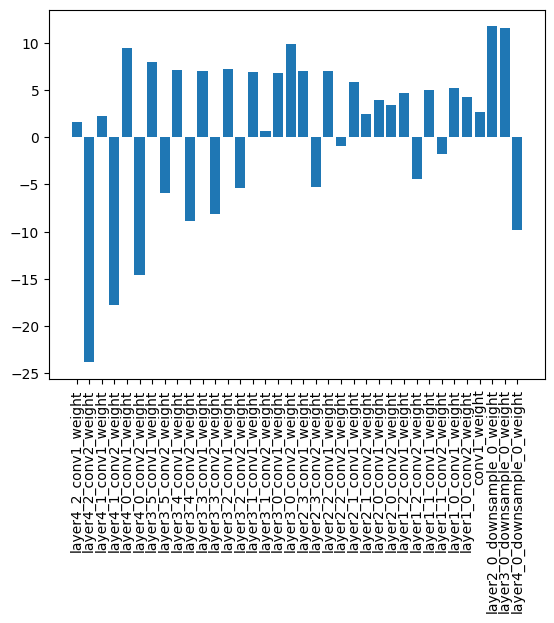

In [20]:
layers = []
sqnrs = []
for layer, layer_info in weight_comparison_a.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += v['sqnr'][0]
        sqnrs[-1] /= len(value['quant'])
plt.bar(layers, sqnrs)
plt.xticks(rotation=90)
plt.show()

In [21]:
weight_comparison_b = ns.extract_weights('float', module_b, 'quant', quantized_b)
ns.extend_logger_results_with_comparison(weight_comparison_b, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr, 'sqnr')

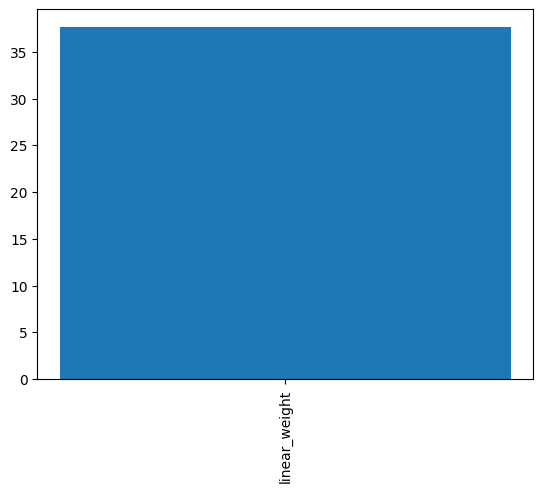

In [ ]:
layers = []
sqnrs = []
for layer, layer_info in weight_comparison_b.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += v['sqnr'][0]
        sqnrs[-1] /= len(value['quant'])
plt.bar(layers, sqnrs)
plt.xticks(rotation=90)
plt.show()

In [23]:
indexes = np.random.randint(0, len(validset), 16)

In [24]:
qlog_a, log_a,  = ns.add_loggers(
    'float', deepcopy(module_a),
    'quant', deepcopy(quantized_a), 
    ns.OutputLogger)

# send an example datum to capture intermediate activations
with torch.inference_mode():
    for i in tqdm(indexes):
        i = int(i)
        x = validset[i][0][None]
        qlog_a(x)
        log_a(x)


# extract intermediate activations
act_comparison_a = ns.extract_logger_info(log_a, qlog_a, ns.OutputLogger, 'quant')

# add SQNR for each comparison, inplace
ns.extend_logger_results_with_comparison(act_comparison_a, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr,'sqnr')


  0%|          | 0/16 [00:00<?, ?it/s]

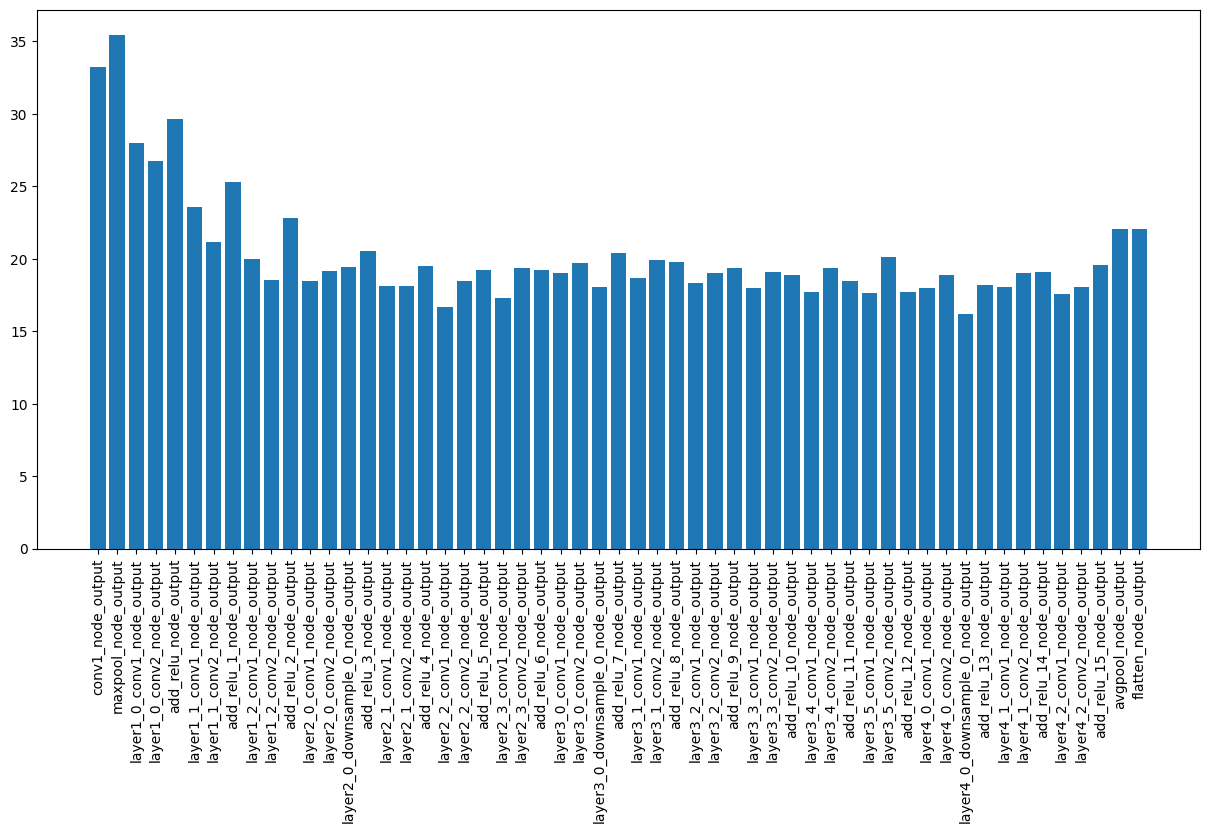

In [30]:
layers = []
sqnrs = []
for layer, layer_info in act_comparison_a.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += sum(v['sqnr']) / len(v['sqnr'])
        sqnrs[-1] /= len(value['quant'])
weight_comparison_b
plt.figure(figsize=(15, 7))
plt.bar(layers, sqnrs)
plt.xticks(rotation=90, size=10)
plt.show()

In [39]:
# weight_comparison_a['layer4_2_conv1']['weight']['float'][0]['values']

In [26]:
log_b, qlog_b,  = ns.add_loggers(
    'float', deepcopy(module_b),
    'quant', deepcopy(quantized_b), 
    ns.OutputLogger)

# send an example datum to capture intermediate activations
with torch.inference_mode():
    for i in tqdm(indexes):
        i = int(i)
        x = validset[i][0][None]
        qy = quantized_a(x)
        y = module_a(x)
        qlog_b(qy)
        log_b(y)


# extract intermediate activations
act_comparison_b = ns.extract_logger_info(log_b, qlog_b, ns.OutputLogger, 'quant')

# add SQNR for each comparison, inplace
ns.extend_logger_results_with_comparison(act_comparison_b, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr,'sqnr')


  0%|          | 0/16 [00:00<?, ?it/s]

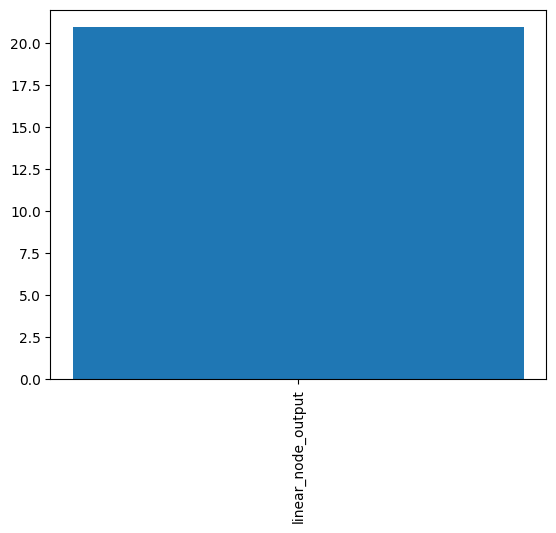

In [27]:
layers = []
sqnrs = []
for layer, layer_info in act_comparison_b.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += sum(v['sqnr']) / len(v['sqnr'])
        sqnrs[-1] /= len(value['quant'])
weight_comparison_b
plt.bar(layers, sqnrs)
plt.xticks(rotation=90)
plt.show()

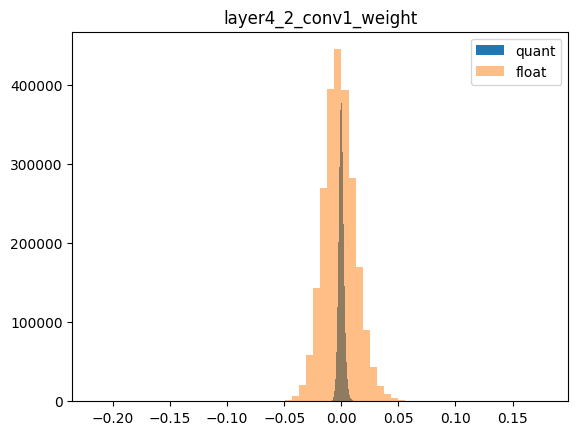

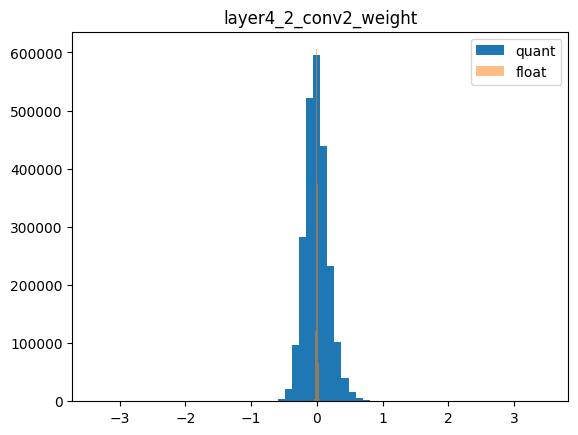

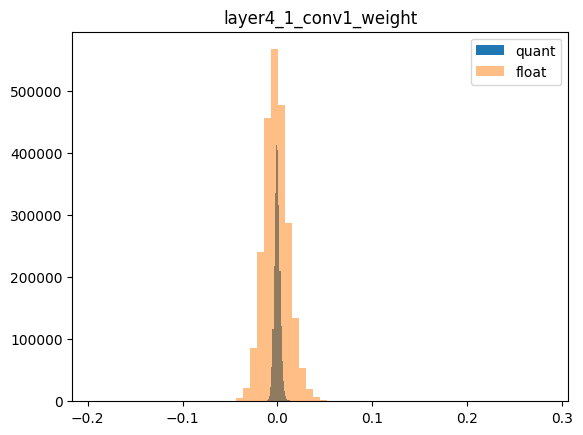

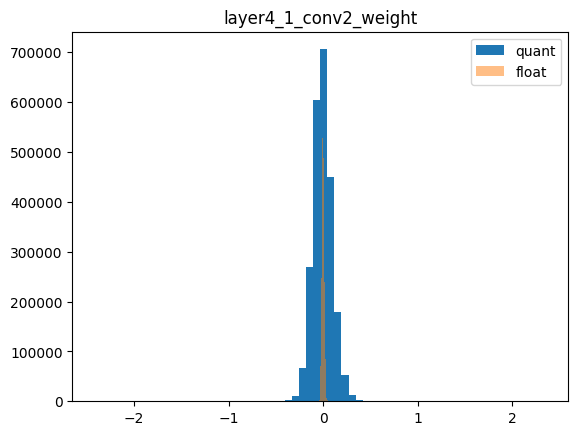

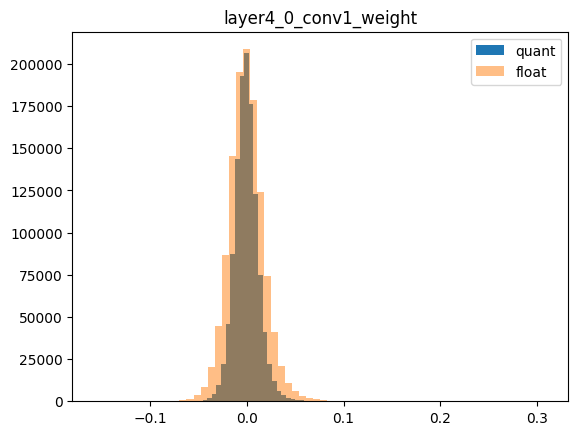

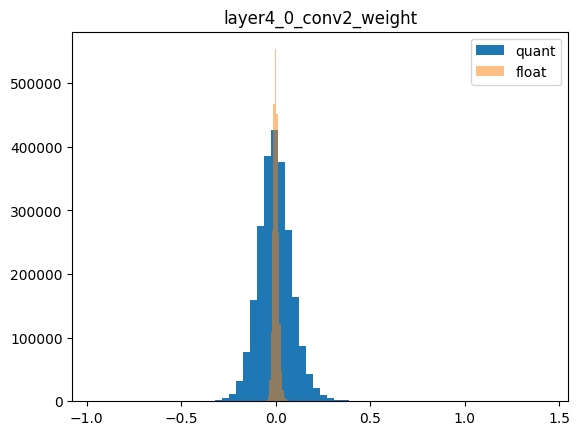

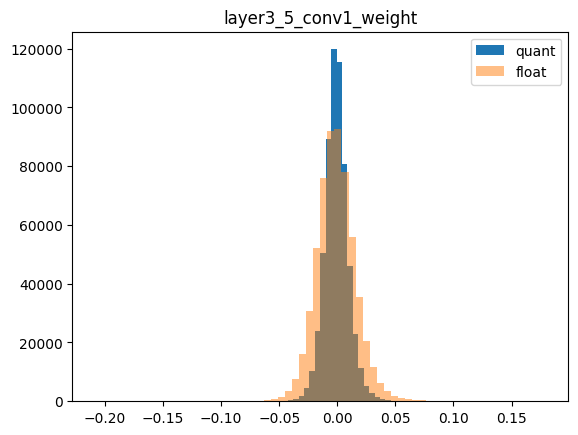

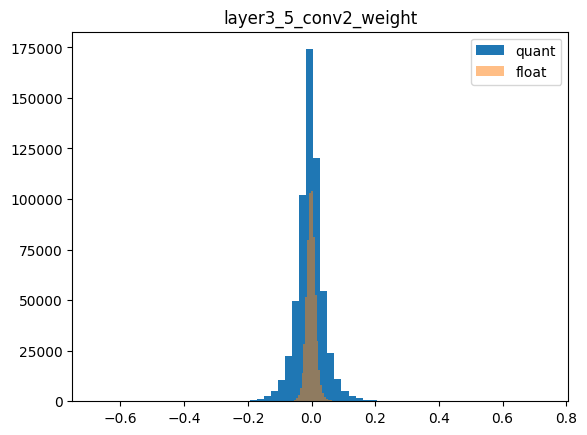

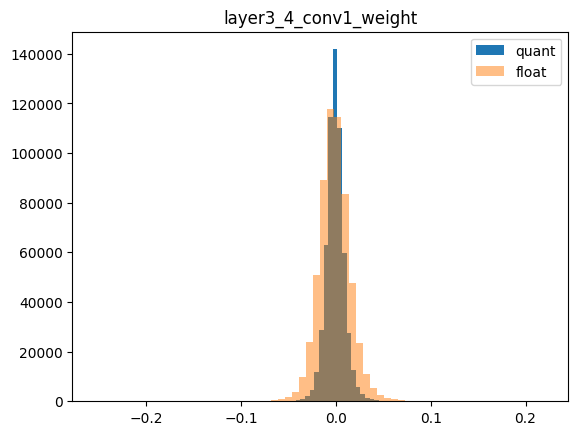

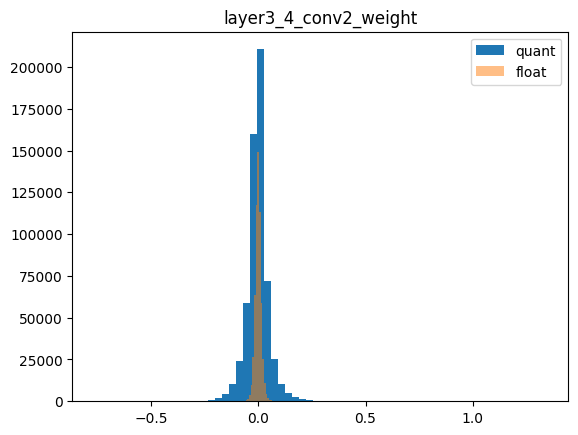

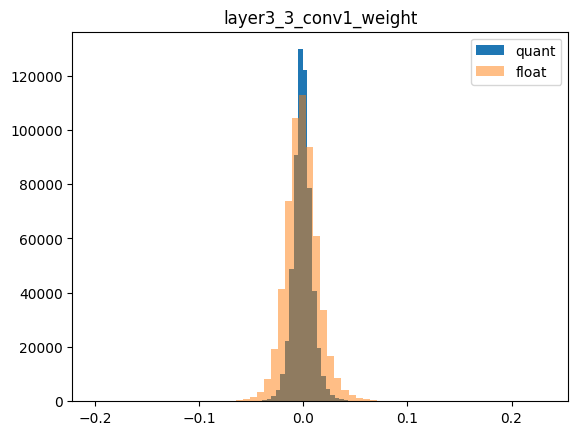

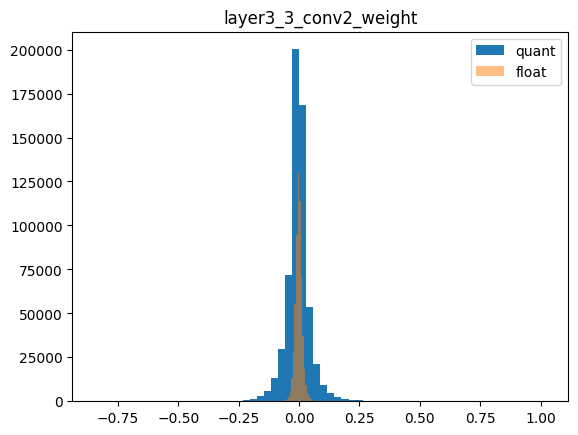

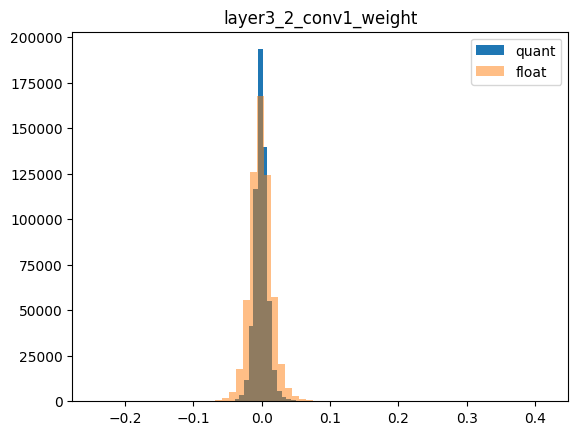

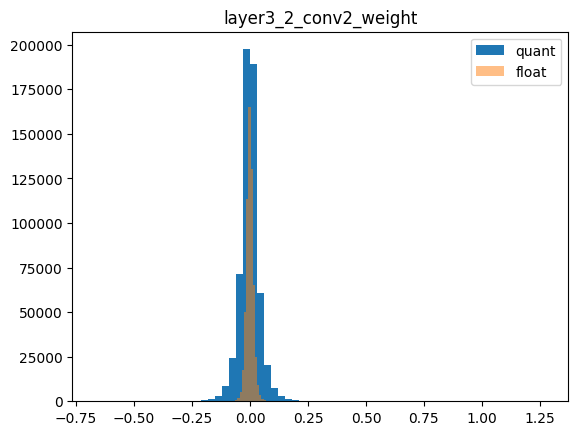

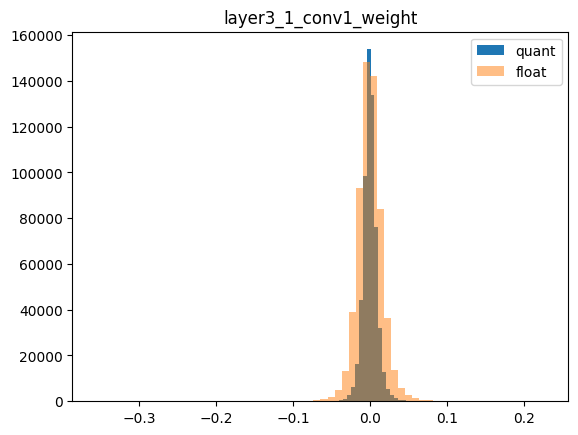

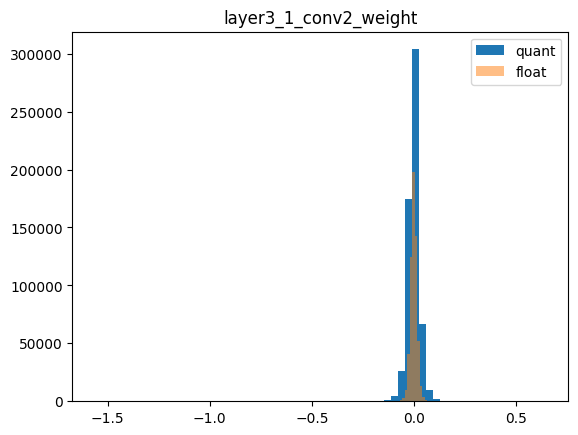

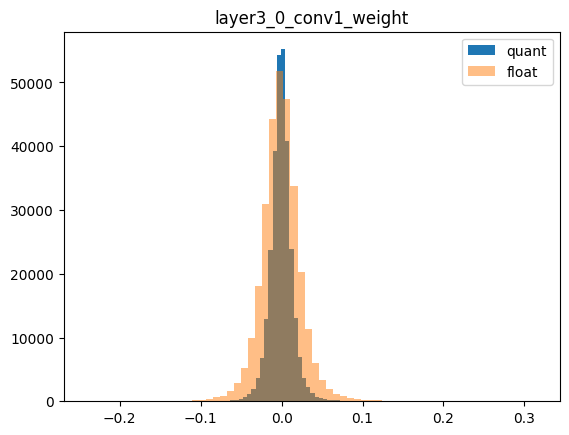

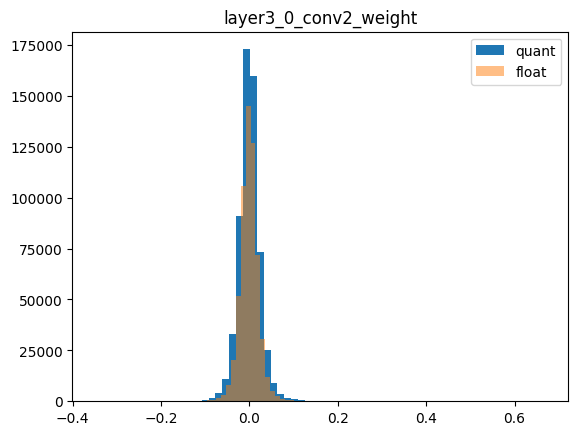

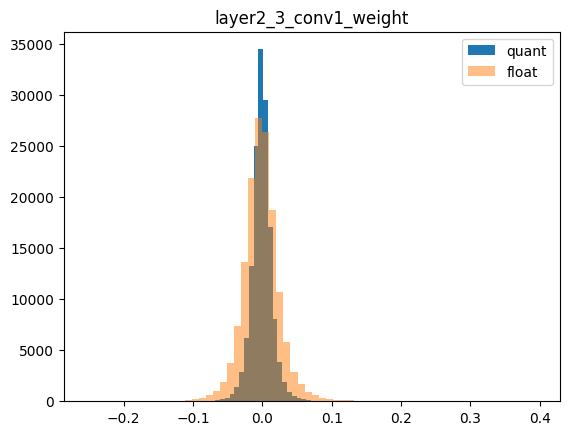

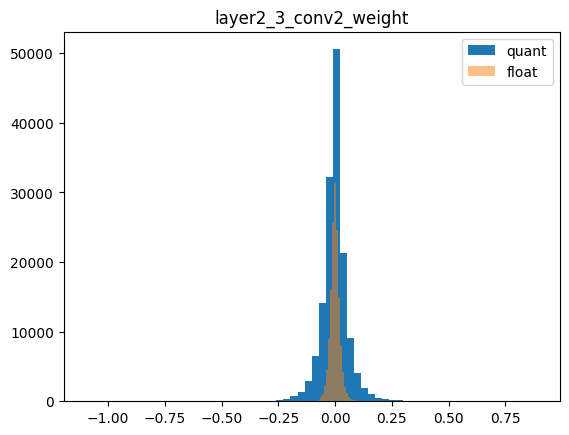

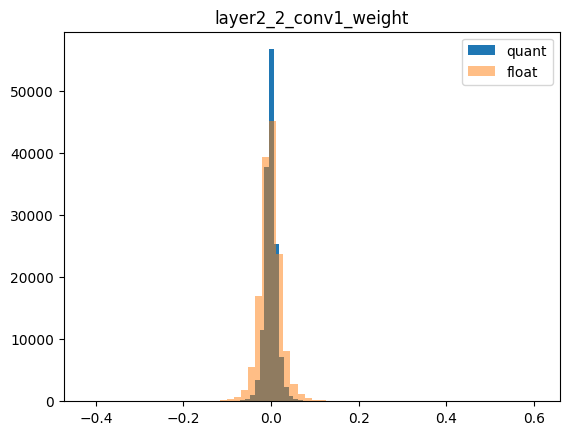

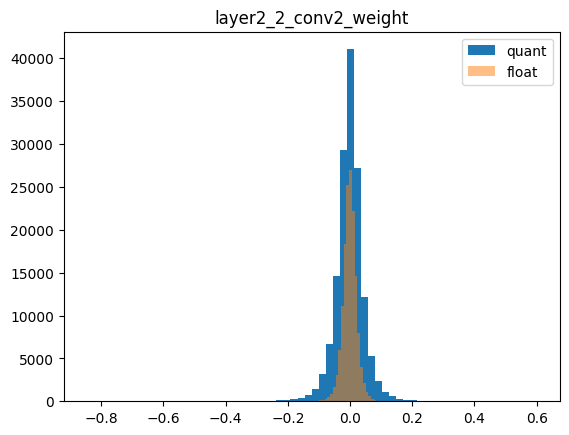

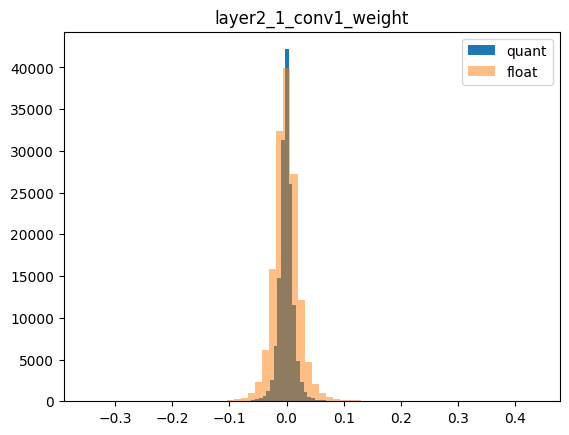

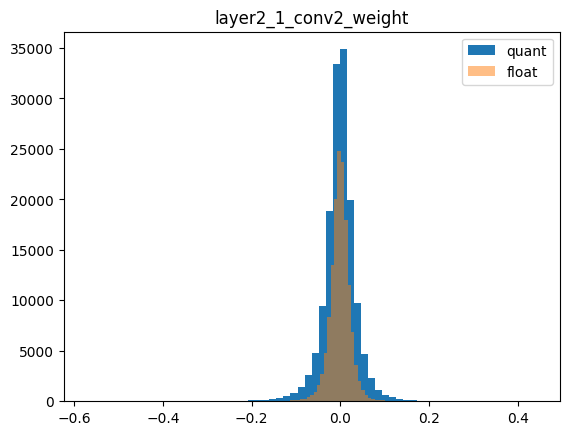

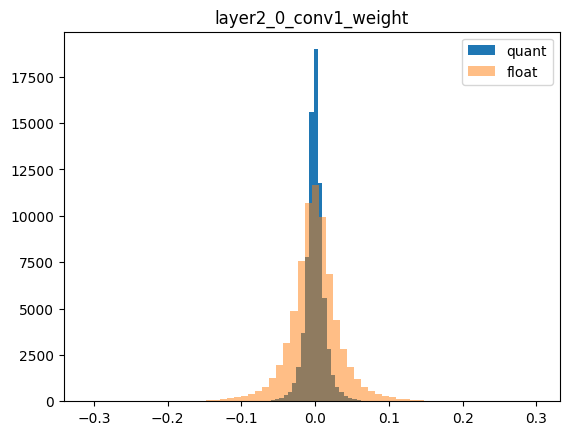

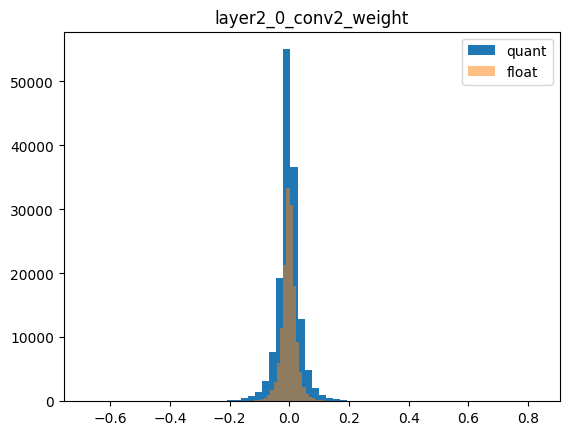

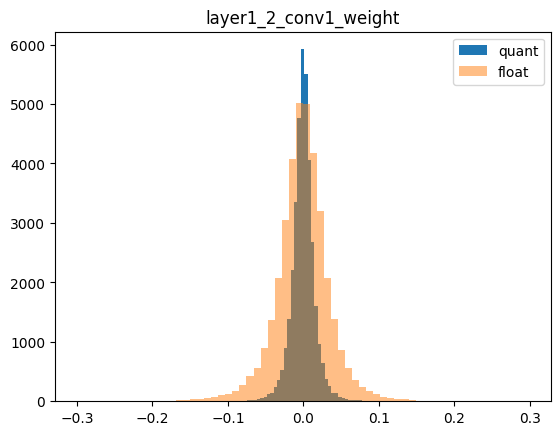

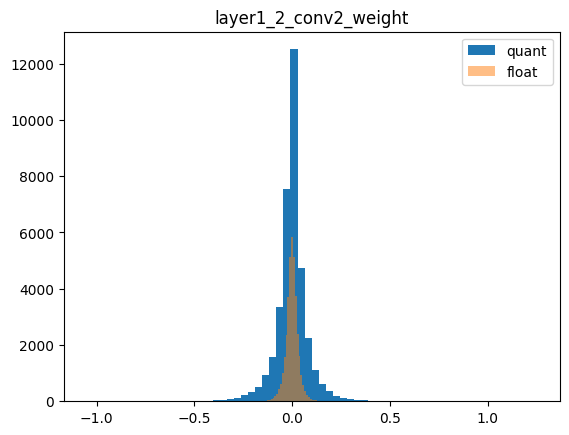

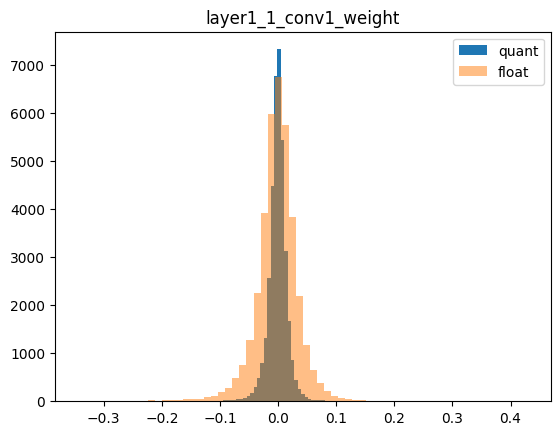

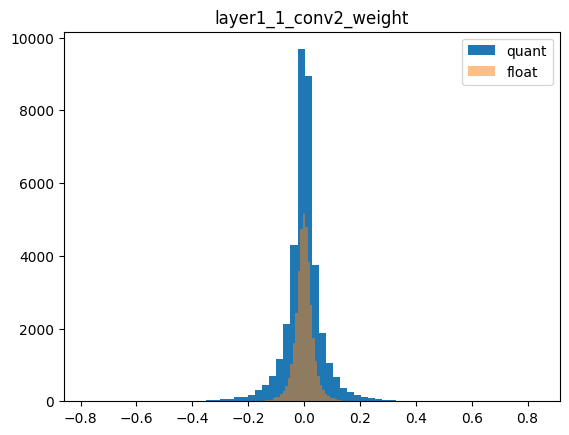

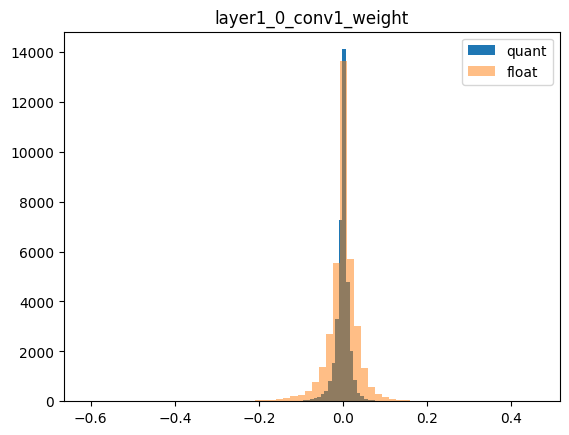

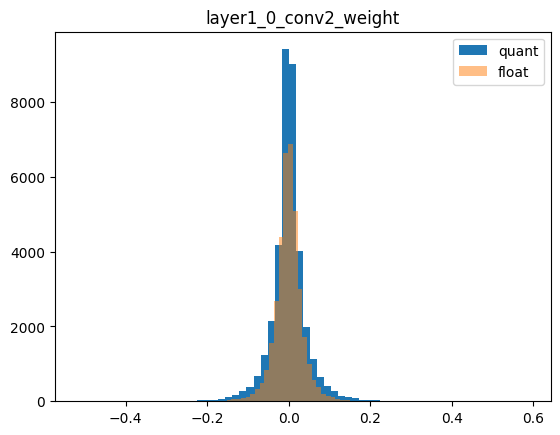

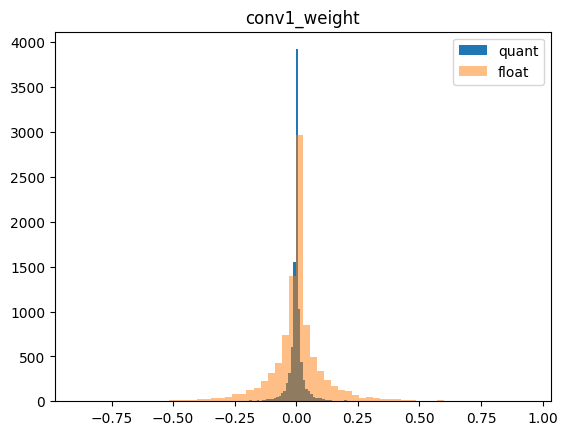

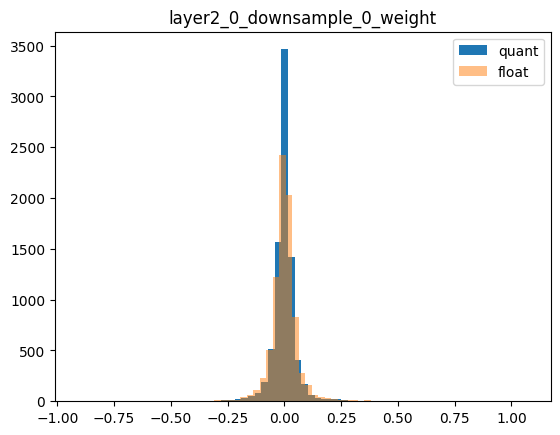

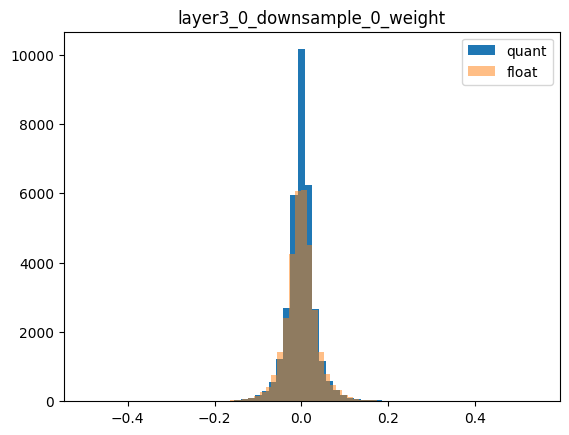

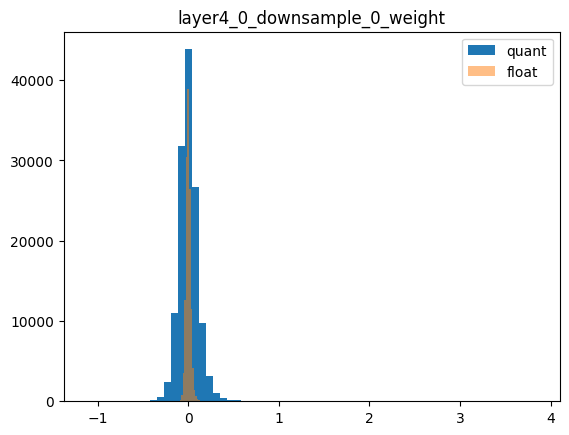

In [29]:
for layer, layer_info in weight_comparison_a.items():
    for key, value in layer_info.items():
        for q, f in zip(value['quant'], value['float']):
            if 'values' in q:
                for qv in q['values']:
                    plt.hist(qv.dequantize().ravel(), bins=64, label='quant')
            if 'values' in f:
                for fv in f['values']:
                    plt.hist(fv.ravel(), bins=64, alpha=0.5, label='float')
            plt.title(layer + '_' + key)
            plt.legend()
            plt.show()
            gc.collect()

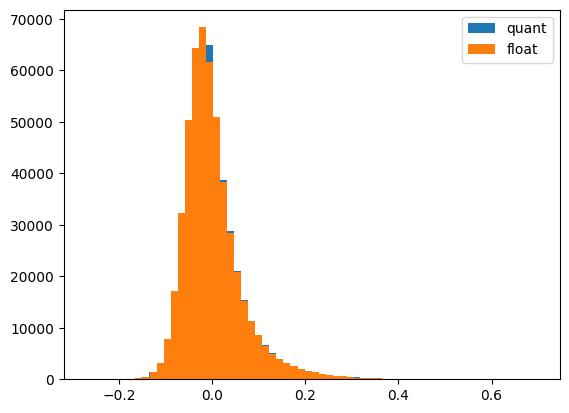

In [28]:
plt.hist(weight_comparison_b['linear']['weight']['float'][0]['values'][0].ravel(), bins=64, label='float')
plt.hist(weight_comparison_b['linear']['weight']['quant'][0]['values'][0].dequantize().ravel(), bins=64, label='quant', alpha=0.5)
plt.legend()
plt.show()

In [170]:
x = torch.randn(1, 512)

In [40]:
epochs=1
batch_size = 1
with torch.inference_mode():
    for _ in range(5):
        with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
            for epoch in range(epochs):
                batch = torch.cat([embeddings[i] for i in np.random.randint(0, len(validset), size=batch_size)])
                with record_function("model_inference"):
                    module_a(x)
        print(batch_size, prof.key_averages().table(sort_by="cpu_time_total"))
        batch_size *= 2

STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


1 ---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         6.58%       5.990ms        99.99%      91.065ms      91.065ms             1  
                     aten::conv2d         0.37%     337.000us        84.70%      77.147ms       2.143ms            36  
                aten::convolution         0.25%     229.000us        84.33%      76.810ms       2.134ms            36  
               aten::_convolution         0.61%     558.000us        84.08%      76.581ms       2.127ms            36  
         aten::mkldnn_convolution        82.36%      75.009ms        83.47%      76.023ms       2.112ms            36  
                 aten::batch_norm     

STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-26 18:49:54 19246:19246 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


4 ---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         6.17%       5.207ms        99.98%      84.311ms      84.311ms             1  
                     aten::conv2d         0.27%     227.000us        84.82%      71.524ms       1.987ms            36  
                aten::convolution         0.24%     202.000us        84.55%      71.297ms       1.980ms            36  
               aten::_convolution         0.55%     464.000us        84.31%      71.095ms       1.975ms            36  
         aten::mkldnn_convolution        82.83%      69.848ms        83.76%      70.631ms       1.962ms            36  
                 aten::max_pool2d     

STAGE:2023-10-26 18:49:55 19246:19246 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-26 18:49:55 19246:19246 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-26 18:49:55 19246:19246 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-10-26 18:49:55 19246:19246 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-26 18:49:55 19246:19246 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-26 18:49:55 19246:19246 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


16 ---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         4.95%       3.262ms        99.97%      65.896ms      65.896ms             1  
                     aten::conv2d         0.23%     149.000us        86.50%      57.022ms       1.584ms            36  
                aten::convolution         0.20%     133.000us        86.28%      56.873ms       1.580ms            36  
               aten::_convolution         0.45%     298.000us        86.08%      56.740ms       1.576ms            36  
         aten::mkldnn_convolution        85.03%      56.048ms        85.62%      56.442ms       1.568ms            36  
                 aten::max_pool2d    

In [183]:
prof.profiler.key_averages()

[<FunctionEventAvg key=aten::cat self_cpu_time=2.106ms cpu_time=21.060us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=model_inference self_cpu_time=3.200ms cpu_time=87.940us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::linear self_cpu_time=464.000us cpu_time=55.940us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::t self_cpu_time=348.000us cpu_time=8.830us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::transpose self_cpu_time=400.000us cpu_time=5.340us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::as_strided self_cpu_time=139.000us cpu_time=0.695us  self_cuda_time=0.000us cuda_time=0.000us input_shap

In [184]:
for key in list(prof.profiler.key_averages()):
    print(key.key, key.cpu_time_total)
    break

aten::cat 2106


In [18]:
with torch.inference_mode():
      with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
            for i, x in enumerate(embeddings):
                  with record_function("model_inference"):
                        y = quantized_b(x)

STAGE:2023-10-19 16:51:51 37696:37696 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-19 16:51:52 37696:37696 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-19 16:51:52 37696:37696 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [19]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        61.95%     279.046ms       100.00%     450.435ms     114.761us          3925  
                quantized::linear        21.17%      95.360ms        24.09%     108.511ms      27.646us          3925  
        aten::quantize_per_tensor         6.70%      30.184ms         7.88%      35.480ms       9.039us          3925  
                 aten::dequantize         4.18%      18.832ms         5.26%      23.680ms       6.033us          3925  
                       aten::item         1.99%       8.977ms         2.00%       9.014ms       0.574us         15700  
                      aten::empty       

In [20]:
gc.collect()

3

In [21]:
print('DEFAULT:', torch.get_num_threads(), torch.get_num_interop_threads())
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
torch.set_num_threads(1), torch.set_num_interop_threads(1)
print(torch.get_num_threads(), torch.get_num_interop_threads())
print(torch.__config__.parallel_info())

DEFAULT: 4 4
1 1
ATen/Parallel:
	at::get_num_threads() : 1
	at::get_num_interop_threads() : 1
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 1
Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 1
Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
std::thread::hardware_concurrency() : 8
Environment variables:
	OMP_NUM_THREADS : 1
	MKL_NUM_THREADS : 1
ATen parallel backend: OpenMP



In [32]:
module_b

Linear(in_features=512, out_features=1000, bias=True)

In [31]:
quantized_b

GraphModule()

In [28]:
with torch.inference_mode():
    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
            for i, x in enumerate(embeddings):
                with record_function("model_inference"):
                        y = module_b(x)

    print(prof.key_averages().table(sort_by="cpu_time_total"))

STAGE:2023-10-19 17:36:20 37696:37696 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-19 17:36:20 37696:37696 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-19 17:36:20 37696:37696 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
       model_inference        23.49%     156.178ms       100.00%     664.999ms     169.426us          3925  
          aten::linear         3.02%      20.079ms        76.23%     506.899ms     129.146us          3925  
           aten::addmm        63.28%     420.826ms        68.13%     453.065ms     115.431us          3925  
               aten::t         1.94%      12.869ms         5.36%      35.677ms       9.090us          3925  
       aten::transpose         2.54%      16.894ms         3.41%      22.696ms       5.782us          3925  
           aten::copy_         2.56%      17.010ms         2.56%      17.010ms       4.334us          3925  
          aten::exp

In [24]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
        for i, x in enumerate(embeddings):
              with record_function("model_inference"):
                     y = quantized_b(x)

print(prof.key_averages().table(sort_by="cpu_time_total"))

STAGE:2023-10-19 16:52:50 37696:37696 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-10-19 16:52:51 37696:37696 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-10-19 16:52:51 37696:37696 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        58.16%     330.290ms       100.00%     567.864ms     144.679us          3925  
                quantized::linear        28.00%     159.015ms        30.78%     174.778ms      44.529us          3925  
        aten::quantize_per_tensor         4.84%      27.488ms         5.83%      33.131ms       8.441us          3925  
                 aten::dequantize         2.96%      16.804ms         4.11%      23.357ms       5.951us          3925  
                       aten::item         2.08%      11.796ms         2.10%      11.948ms       0.761us         15700  
                      aten::empty       

# 4 CORES

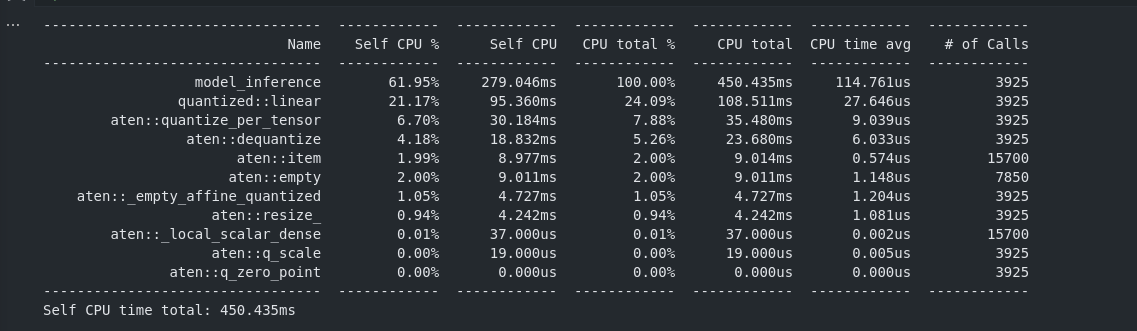

In [ ]:
with torch.inference_mode():
    wt_compare_dict = ns.compare_weights(model.state_dict(), quantized_model.state_dict())

In [ ]:
def sqnr(x: torch.Tensor, y: torch.Tensor, eps: float = 1e-8) -> float:
    ps = torch.norm(x)
    pn = torch.norm(x - y)
    return 20.0 * torch.log10(ps / (pn))

In [ ]:
from matplotlib import pyplot as plt

  0%|          | 0/37 [00:00<?, ?it/s]

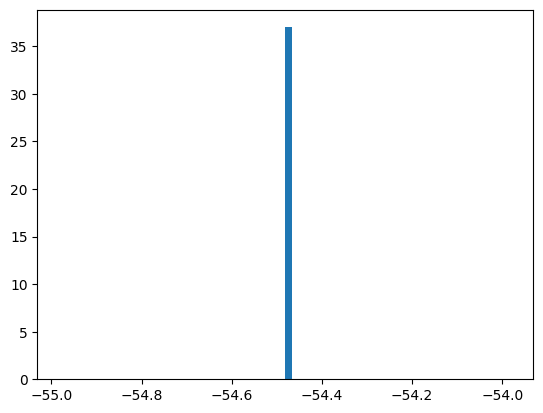

In [ ]:
sqnr_dict = {}
for key, value in tqdm(wt_compare_dict.items()):
    f = value['float']
    q = value['quantized']
    sqnr_dict[key] = sqnr(x, y)

plt.hist(list(sqnr_dict.values()), bins=64)
plt.show()

In [ ]:
extract_weights = nsfx.extract_weights('float', model, 'quantized', quantized_model)
# extract_weights['heads_head']['weight']['quantized'][0]['values']

KeyError: 'heads_head'

In [ ]:
logged_model, logged_quantized_model = nsfx.add_loggers('float', model, 'quantized', quantized_model, nsfx.OutputLogger)

In [ ]:
limit = 16
y1_hat = []
y2_hat = []
with torch.inference_mode():
    for i, (x, y) in tqdm(enumerate(valid_dataloader)):
        if i >= limit:
            break
        y1 = logged_model(x).argmax(-1)
        y2 = logged_quantized_model(x).argmax(-1)
        y1_hat.append(y1)
        y2_hat.append(y2)

0it [00:00, ?it/s]

In [ ]:
info = nsfx.extract_logger_info(logged_model, logged_quantized_model, nsfx.OutputLogger, 'model')

In [ ]:
results = []
dist = []

In [ ]:
for key, value in info.items():
    if value['node_output']['float'][0]['values']:
        f = torch.stack(value['node_output']['float'][0]['values'])
        q = torch.stack(value['node_output']['quantized'][0]['values'])
        s = sqnr(f, q.dequantize()).item()
        if s <= 15:
            print(info[key]['node_output']['float'][0]['ref_node_name'], info[key]['node_output']['quantized'][0]['ref_node_name'])
        n = (f - q.dequantize()).abs().mean()
        results.append(s)
        dist.append(n)

encoder_layers_encoder_layer_0_dropout encoder_layers_encoder_layer_0_dropout
encoder_layers_encoder_layer_0_ln_2 encoder_layers_encoder_layer_0_ln_2
encoder_layers_encoder_layer_0_mlp_0 encoder_layers_encoder_layer_0_mlp_0
encoder_layers_encoder_layer_0_mlp_2 encoder_layers_encoder_layer_0_mlp_2
add_2 add_2
encoder_layers_encoder_layer_1_ln_1 encoder_layers_encoder_layer_1_ln_1
encoder_layers_encoder_layer_1_dropout encoder_layers_encoder_layer_1_dropout
add_3 add_3
encoder_layers_encoder_layer_1_ln_2 encoder_layers_encoder_layer_1_ln_2
encoder_layers_encoder_layer_1_mlp_2 encoder_layers_encoder_layer_1_mlp_2
encoder_layers_encoder_layer_1_mlp_3 encoder_layers_encoder_layer_1_mlp_3
encoder_layers_encoder_layer_1_mlp_4 encoder_layers_encoder_layer_1_mlp_4
add_4 add_4
encoder_layers_encoder_layer_2_ln_1 encoder_layers_encoder_layer_2_ln_1
encoder_layers_encoder_layer_2_dropout encoder_layers_encoder_layer_2_dropout
add_5 add_5
encoder_layers_encoder_layer_2_ln_2 encoder_layers_encoder_l

In [47]:
list(map(bin, np.array([1,2], dtype=np.uint8).ravel()))

['0b1', '0b10']

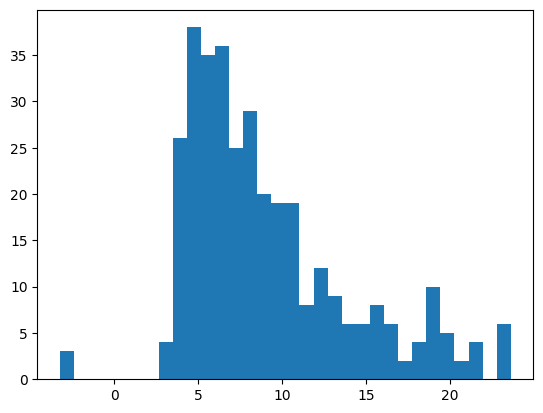

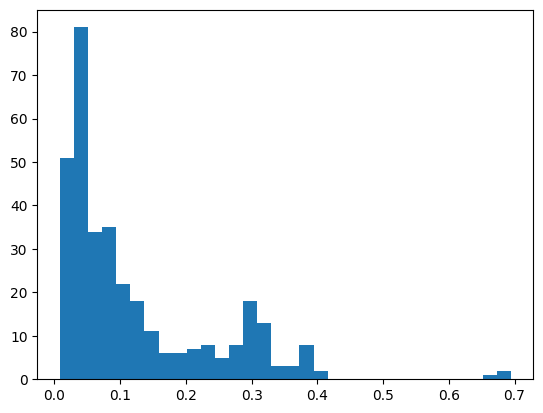

In [ ]:
plt.hist(results, bins=32)
plt.show()
plt.hist(dist, bins=32)
plt.show()

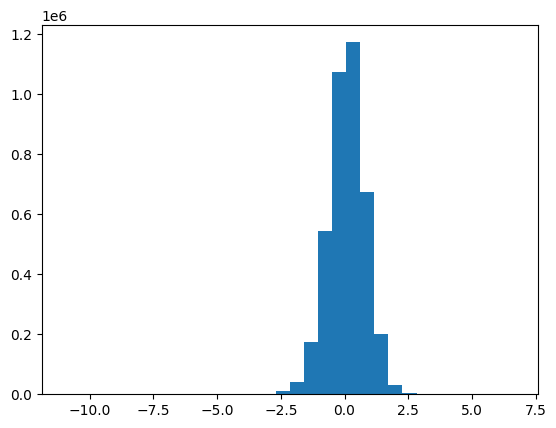

In [ ]:
plt.hist(torch.cat(Y).ravel().numpy(), bins=32, alpha=0.5)
# plt.hist(torch.cat(Y).ravel().numpy(), bins=32, alpha=0.5)
plt.show()

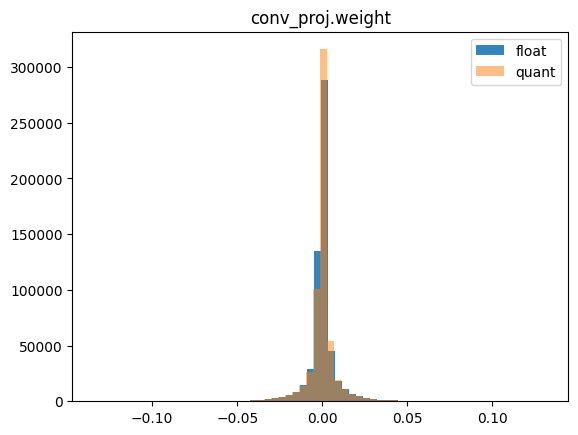

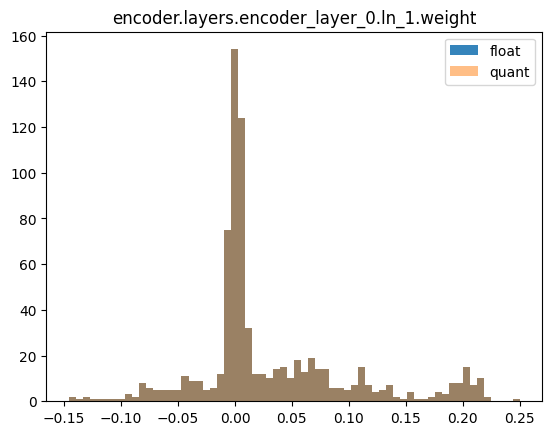

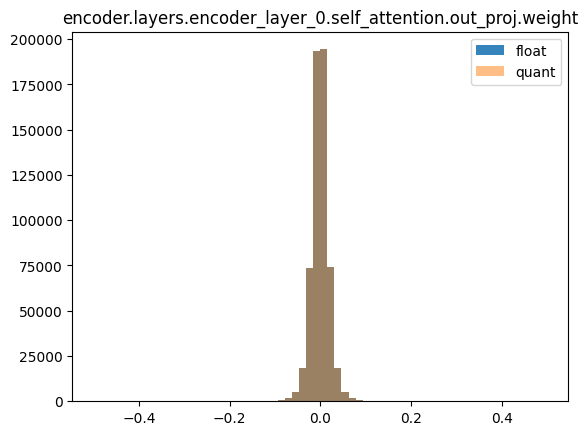

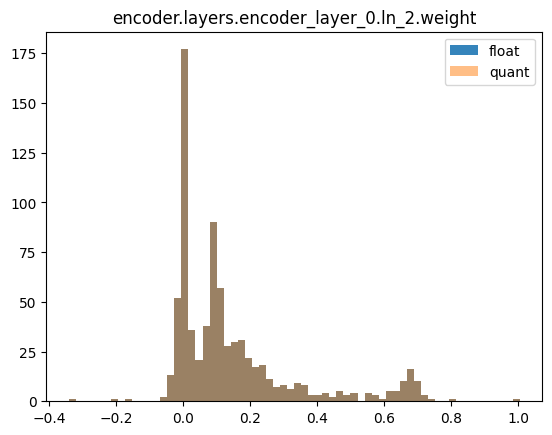

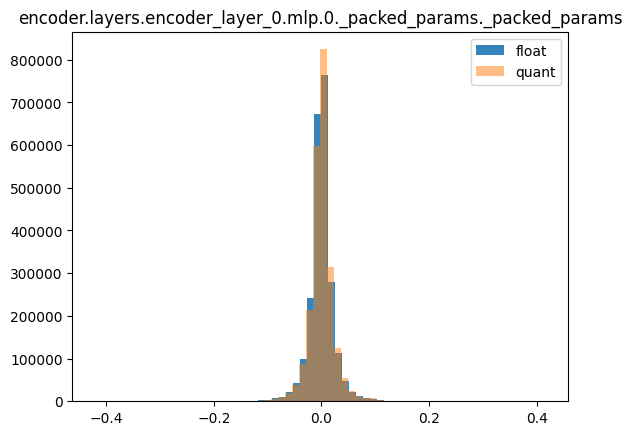

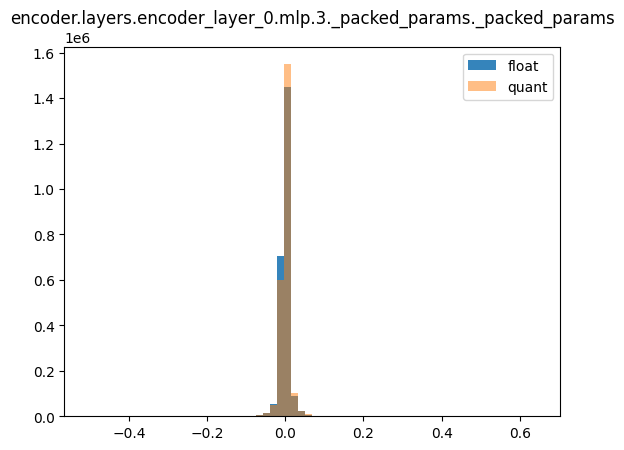

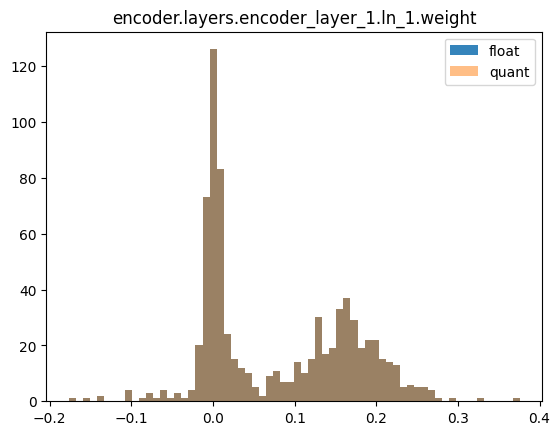

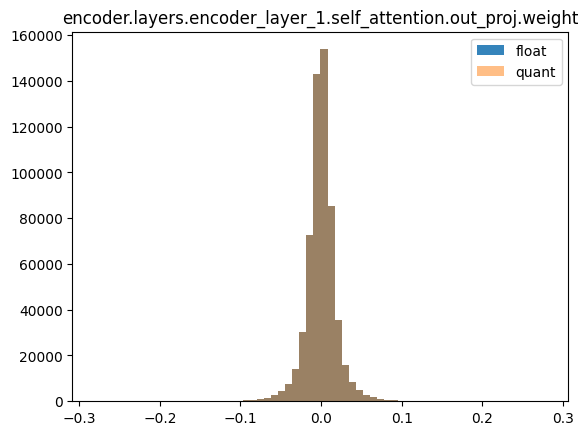

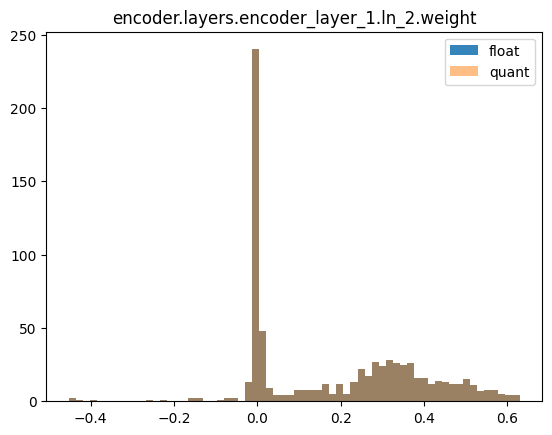

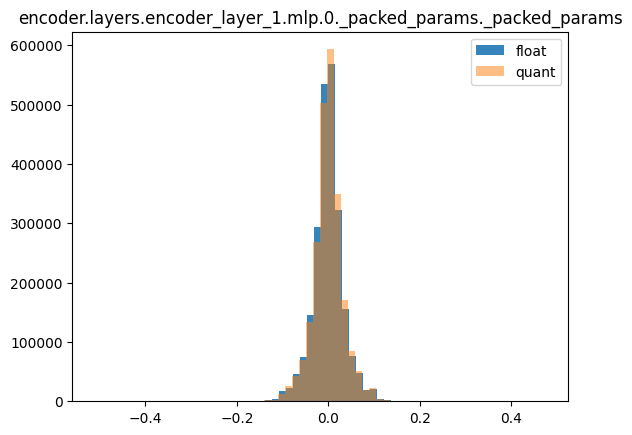

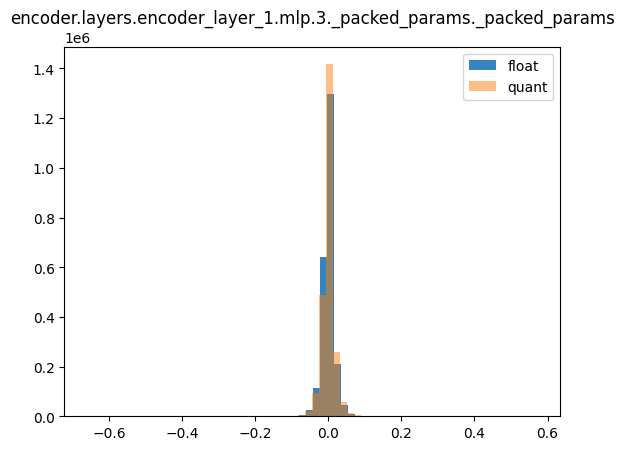

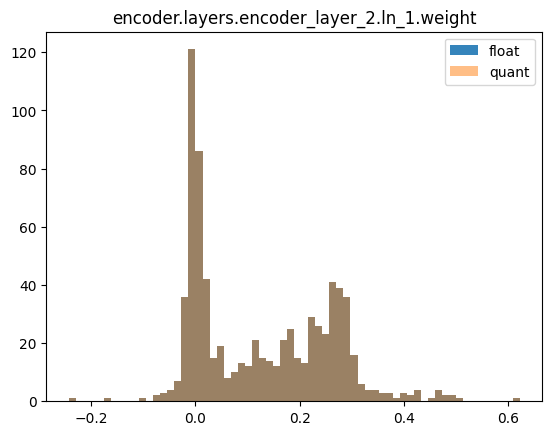

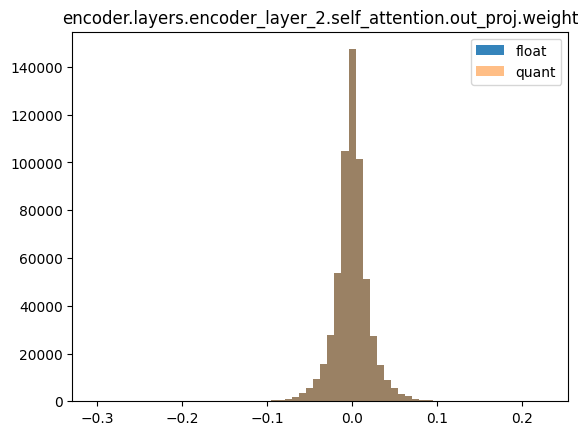

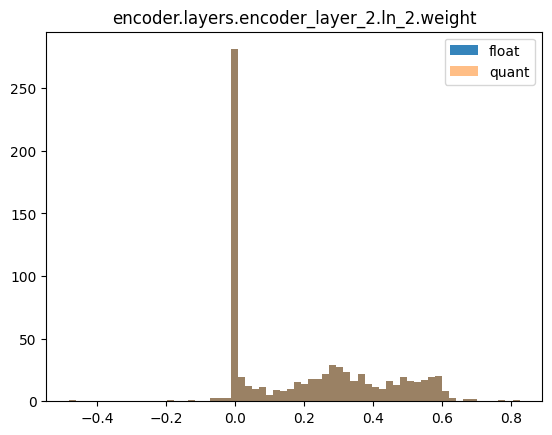

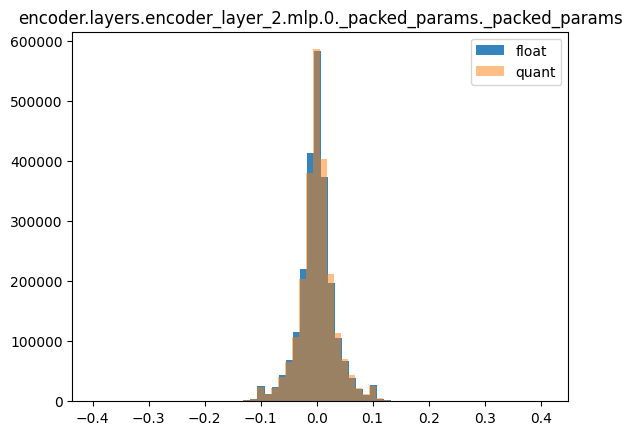

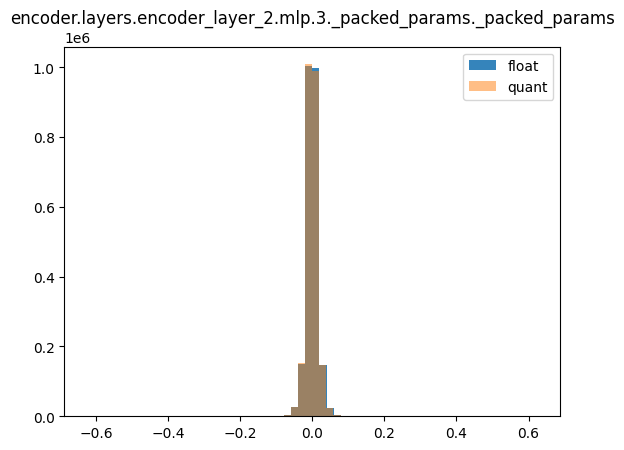

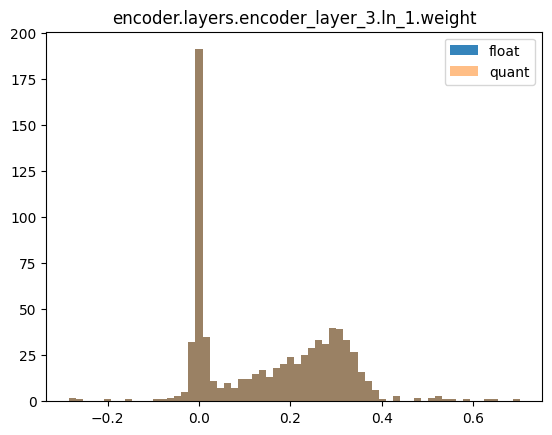

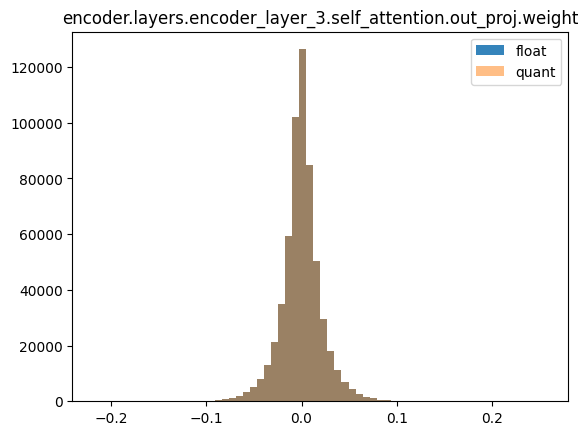

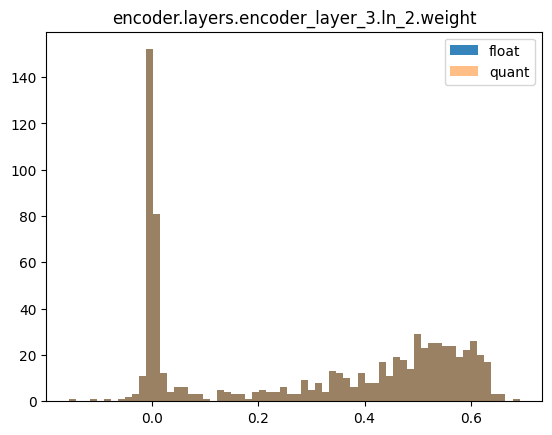

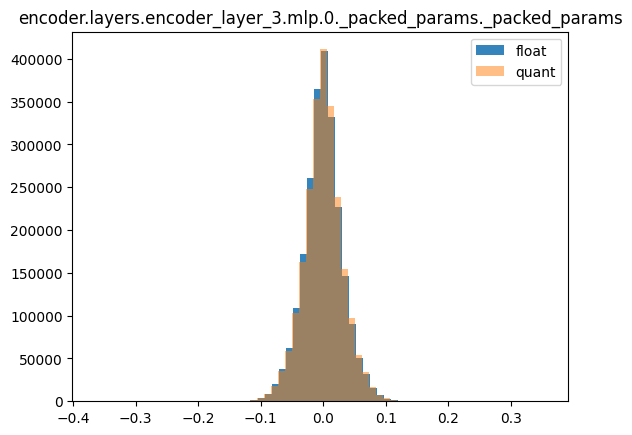

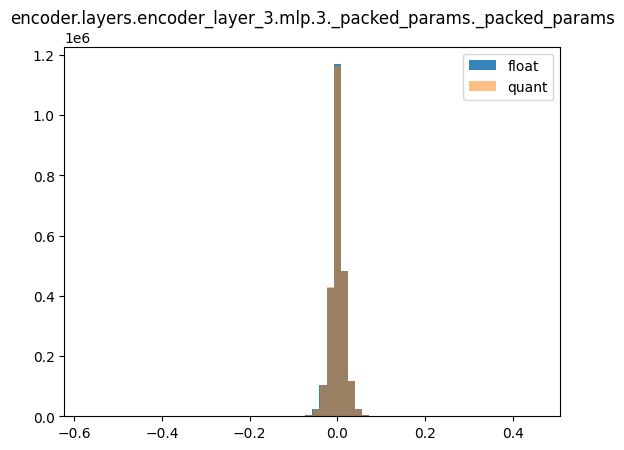

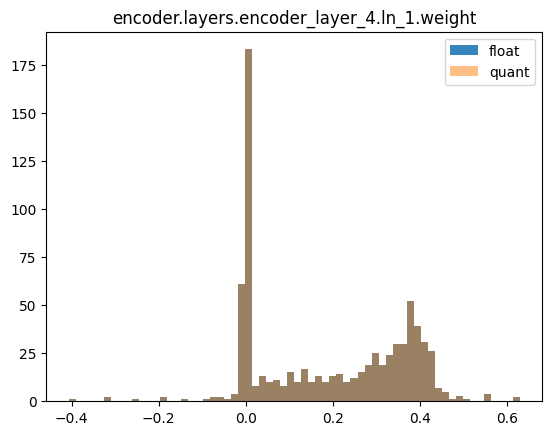

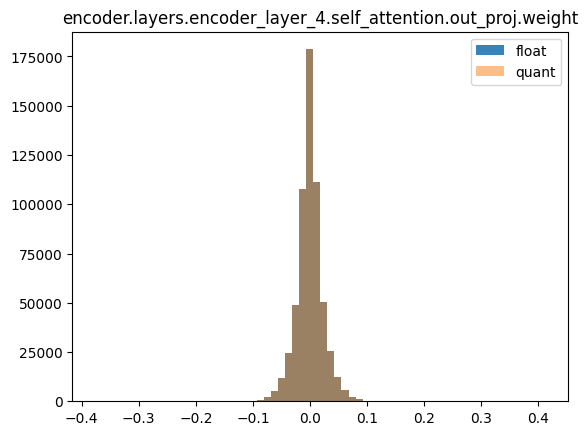

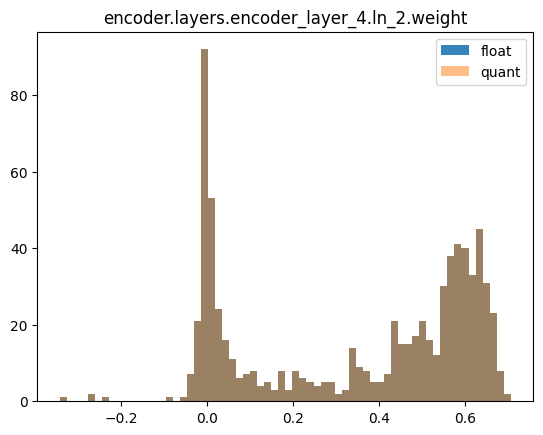

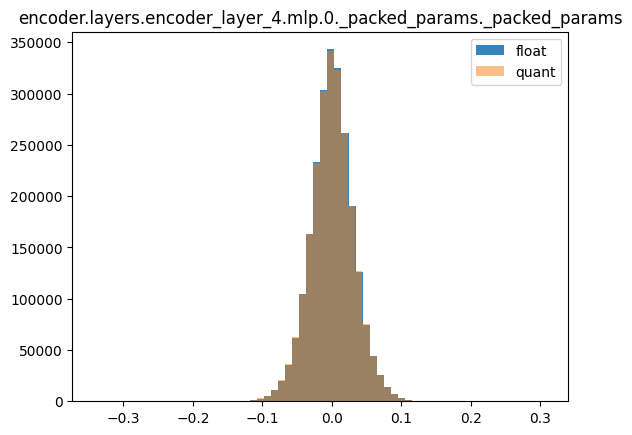

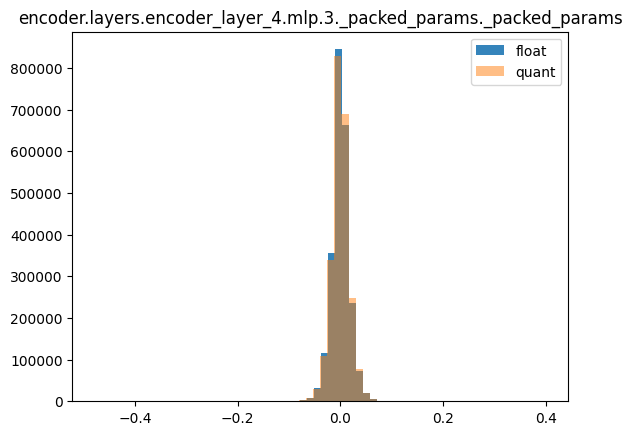

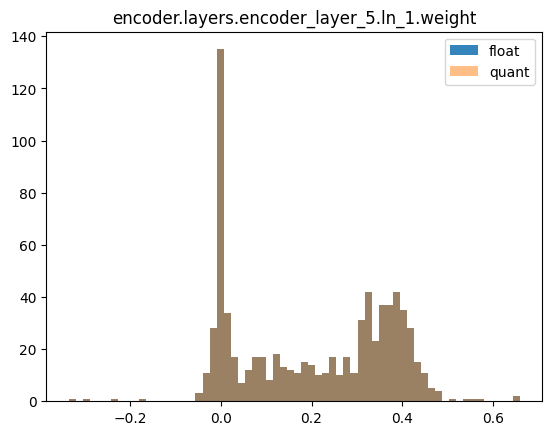

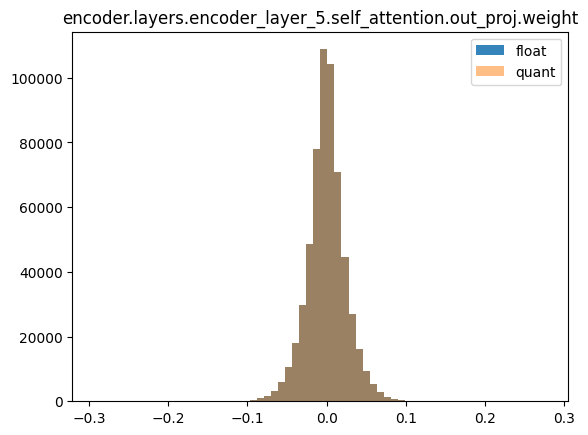

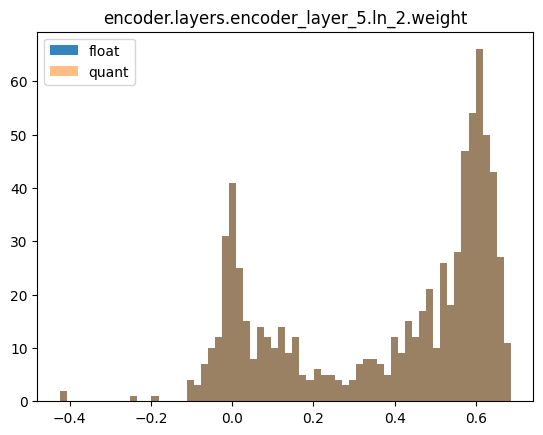

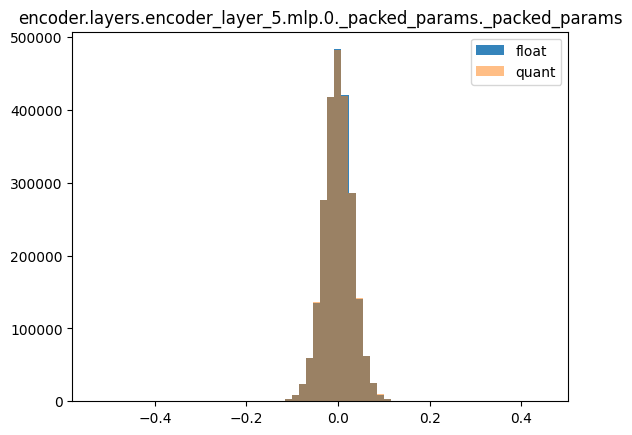

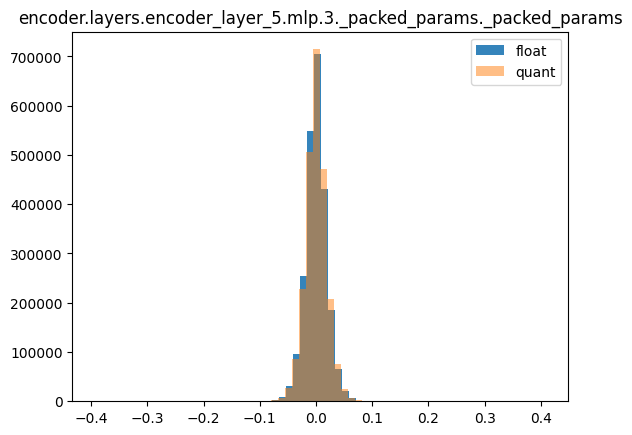

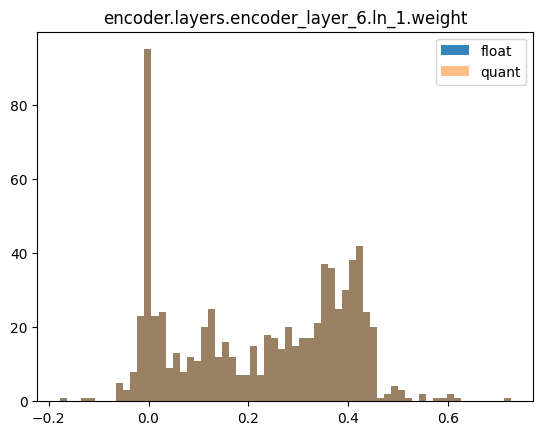

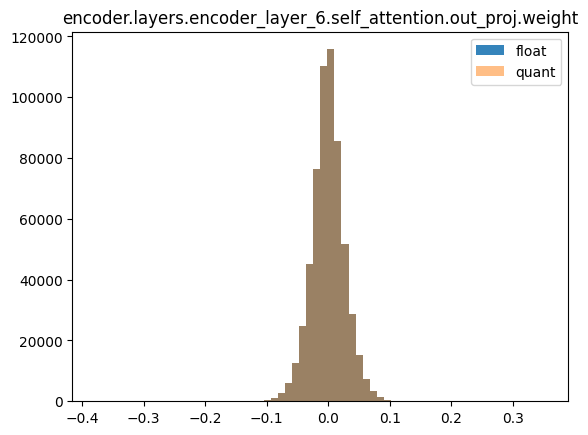

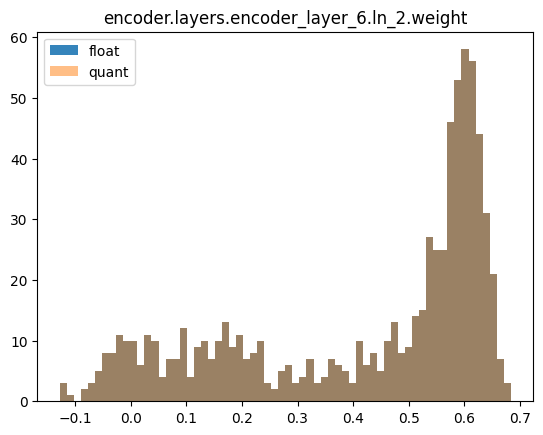

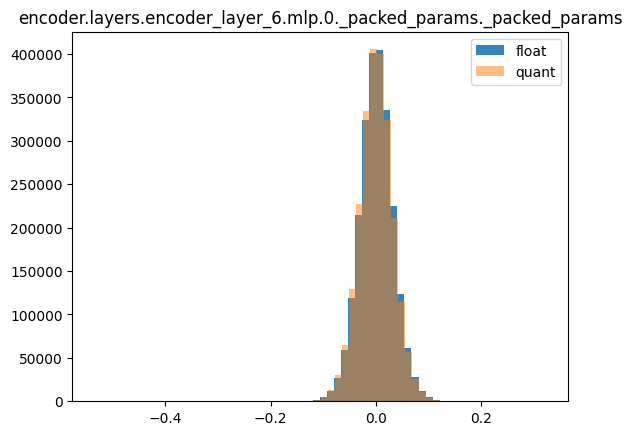

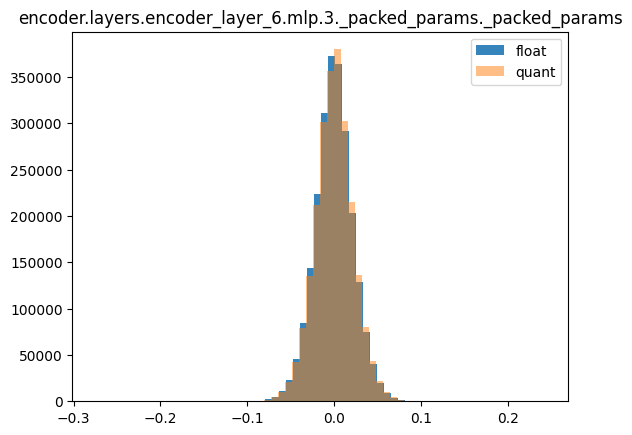

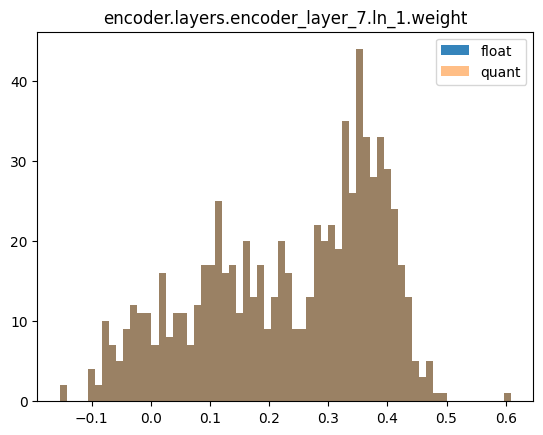

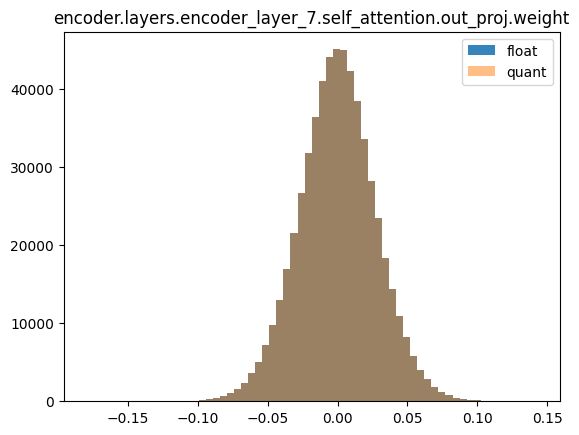

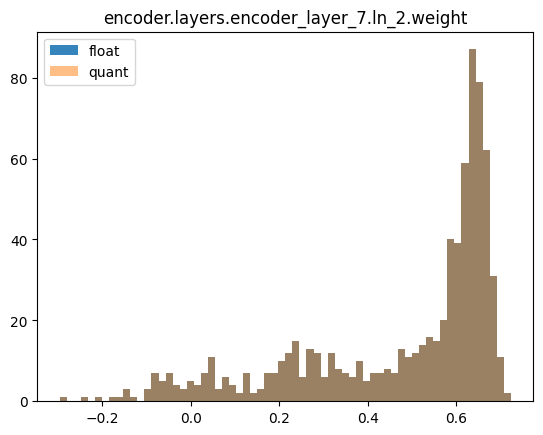

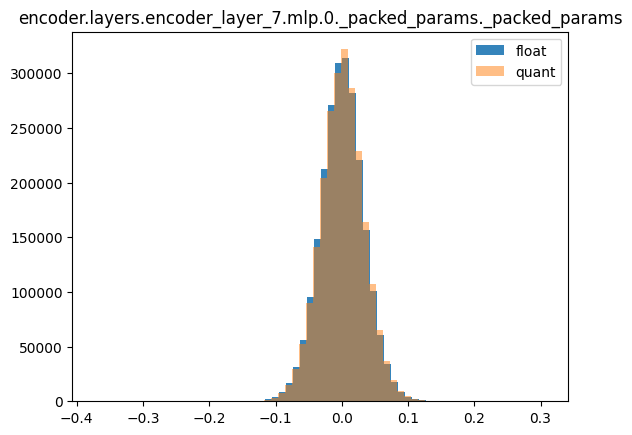

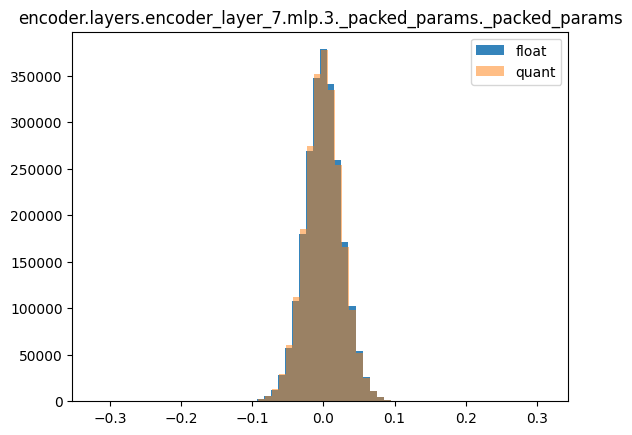

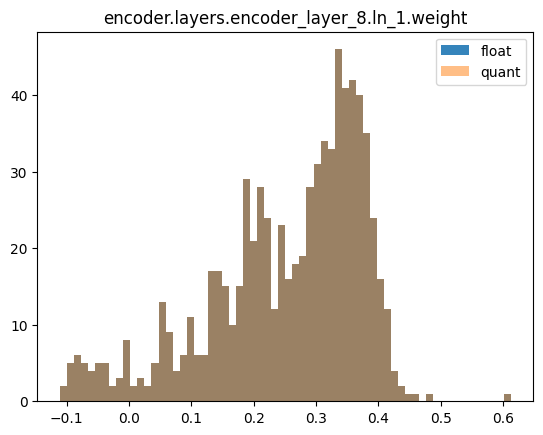

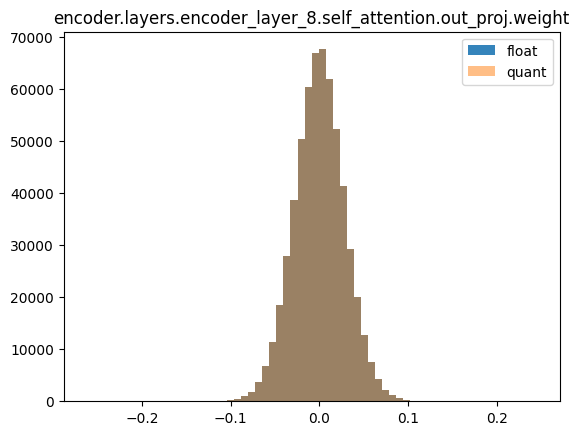

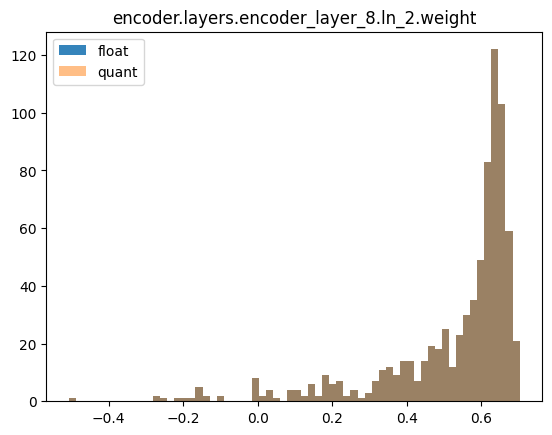

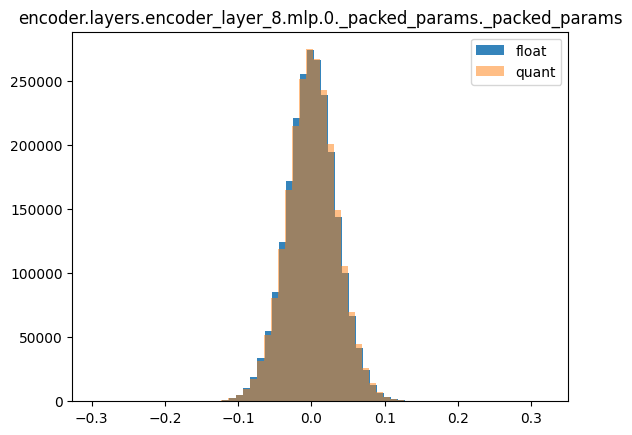

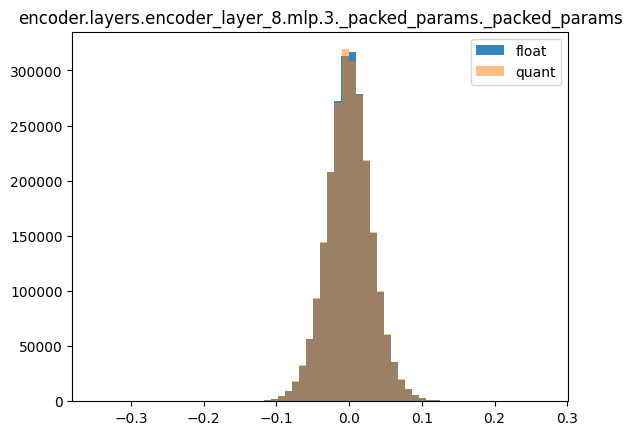

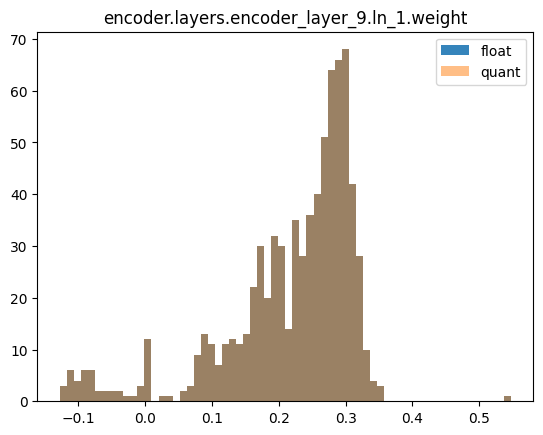

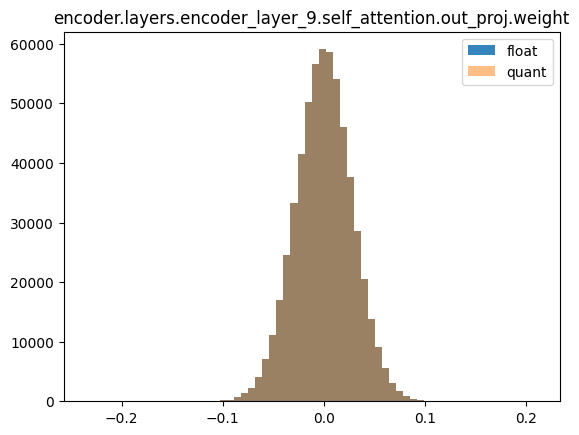

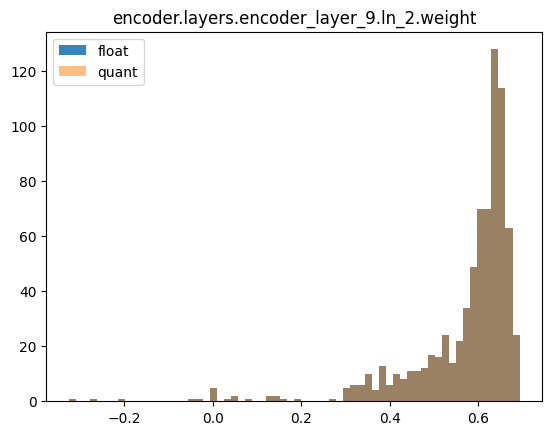

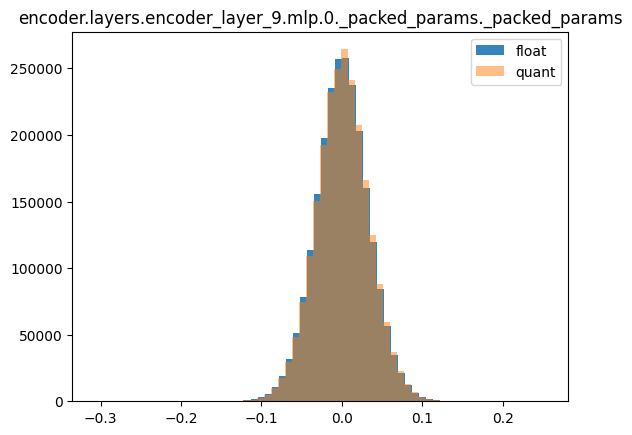

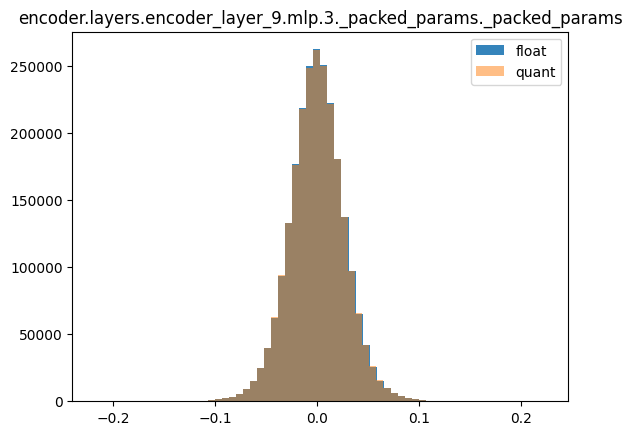

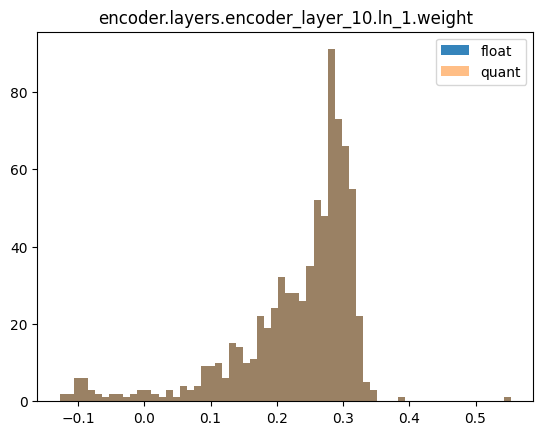

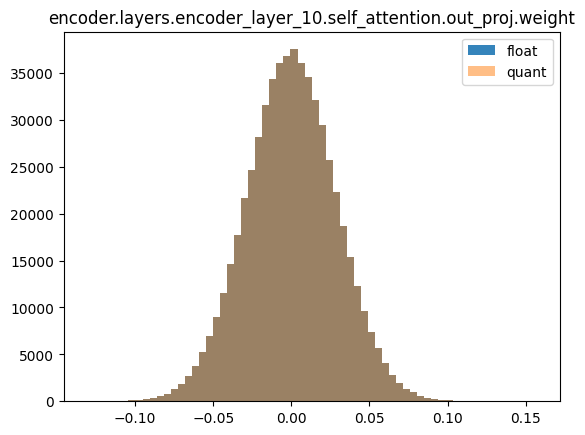

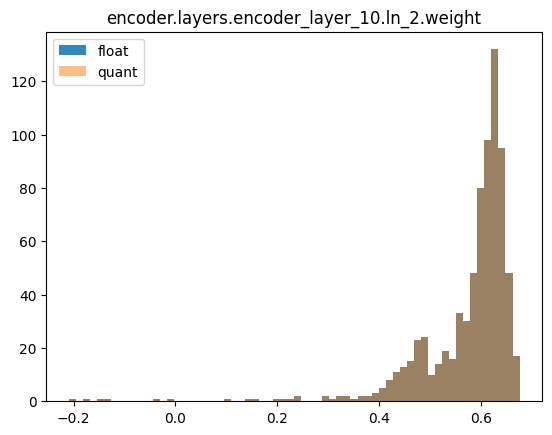

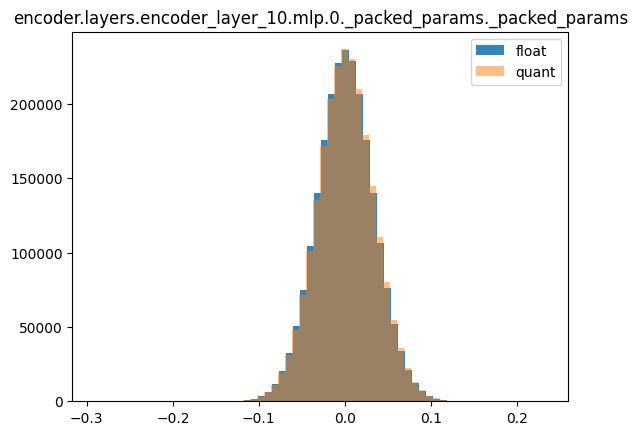

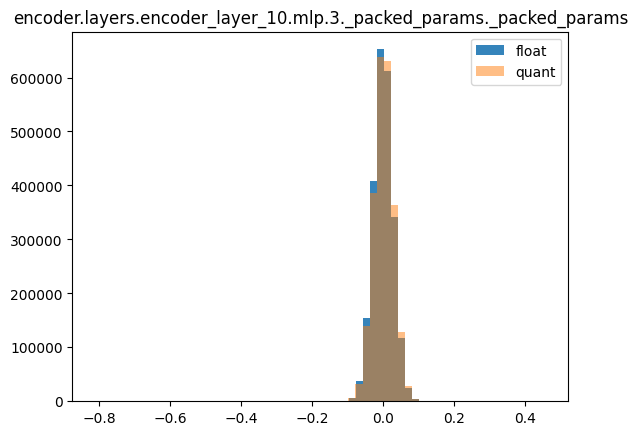

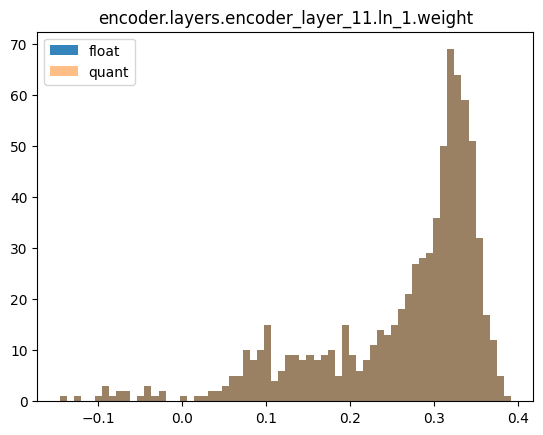

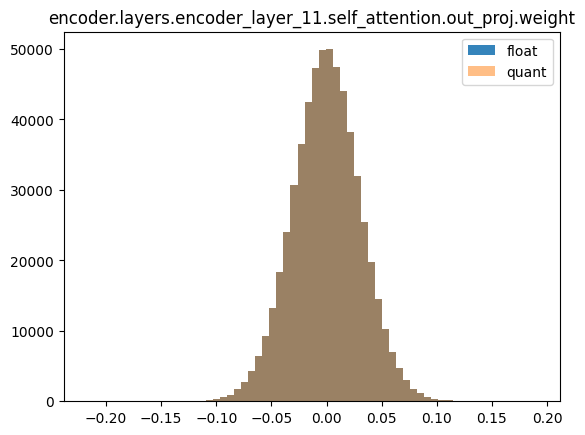

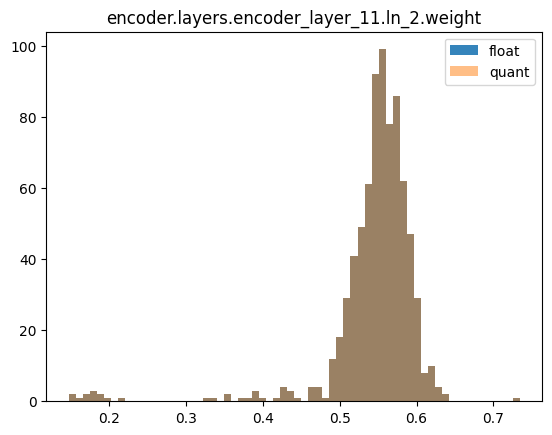

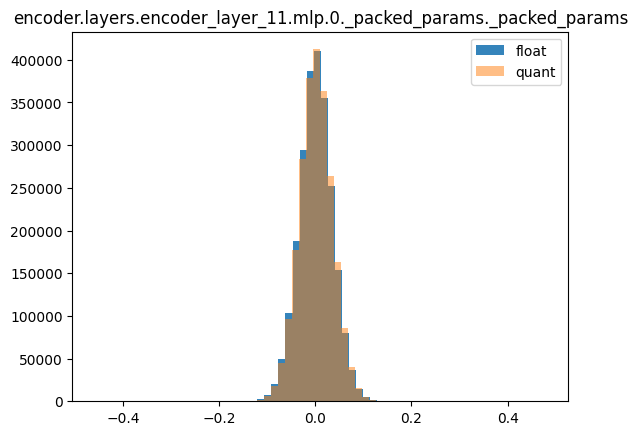

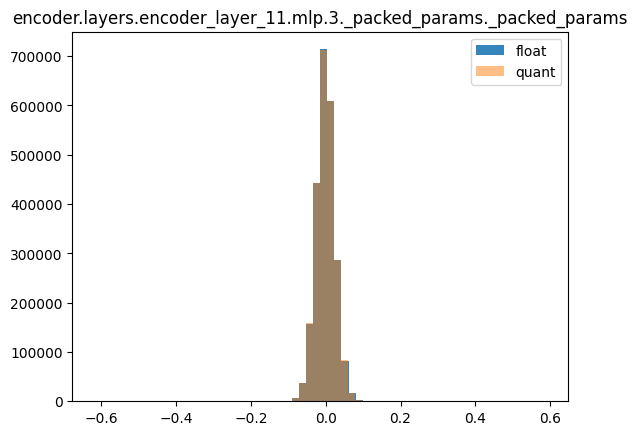

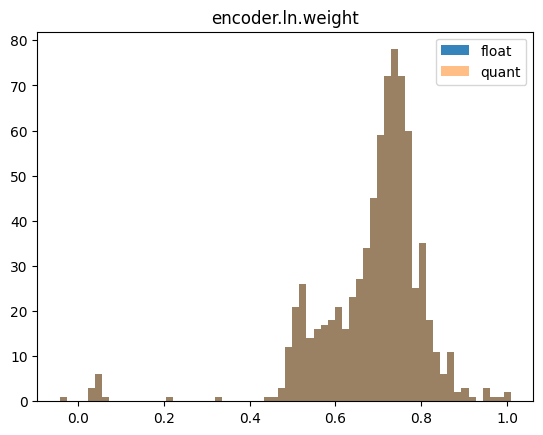

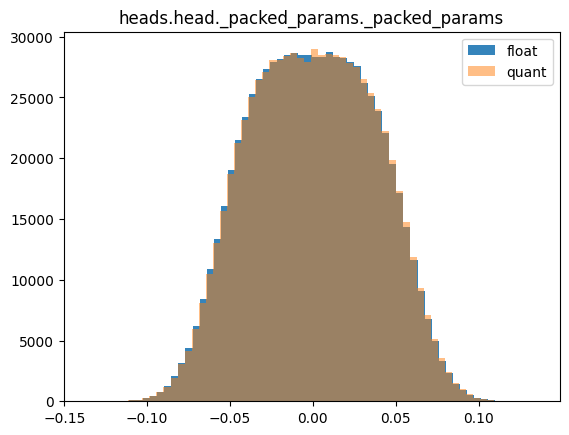

In [ ]:
for layer, d in tqdm(wt_compare_dict.items()):
    f = d['float']
    q = d['quantized']
    plt.hist(f.ravel(), bins=64, alpha=0.9, label='float')
    plt.hist(q.dequantize().ravel(), bins=64, alpha=0.5, label='quant')
    plt.title(layer)
    plt.legend()
    plt.show()